# Project Nexus: HR Attrition Prediction & Organizational Network Analysis

## 1. Project Overview
**Objective:**
Traditional HR analytics only predict *who* might leave. **Project Nexus** goes a step further by identifying **"Attrition Contagion"**—predicting how the departure of key influencers (high PageRank employees) can trigger a chain reaction of resignations within the team.

**Our Novel Approach:**
We integrate **Machine Learning (XGBoost)** with **Organizational Network Analysis (ONA)**. By constructing a simulated social network based on employee homophily, we can quantify "hidden" social capital and identify high-risk clusters.

In [1]:
# Install necessary libraries
!pip install pandas numpy matplotlib seaborn networkx scikit-learn
!pip install xgboost
!pip install shap

# 2. Data Architecture Phase

**Author:** Luo Yurou

This notebook covers **Phase 1** of the project: *Data Engineering and Network Construction*. The pipeline is divided into four core modules:

### Module 1: Data Initialization & Exploratory Analysis
* **Preprocessing:** Dimensionality reduction by removing zero-variance features (`Over18`, `EmployeeCount`, `StandardHours`) and ensuring data integrity via forward-fill imputation.
* **EDA:** Analyzing class imbalance to justify synthetic data generation (SMOTE) and utilizing heatmaps to identify multicollinearity for cleaner feature selection.

### Module 2: Network Topology Construction (The Innovation)
> *"Simulating the Invisible": Constructing a synthetic Homophily Graph to model information flow where no raw network data existed.*

* **Logic:** Edges are established using a **Hard Constraint** (Departmental matching) and a **Soft Constraint** (Attribute Similarity).
* **Methodology:** Utilizing K-Nearest Neighbors ($k=5$) on scaled `Age`, `JobLevel`, and `Tenure` to link employees with similar professional profiles.

### Module 3: Advanced Feature Engineering
* **Individual "Golden Features":** Deriving behavioral metrics including `Tenure_Ratio` (Loyalty), `Income_Per_Age` (Fairness), `Burnout_Index` (Stress), and `Relative_Sat_to_Dept` (Isolation/Relative Deprivation).
* **Network Metrics:** Calculating `Neighbor_Risk_Score` to model "Attrition Contagion", `PageRank_Score` to identify influential nodes, and `Clustering_Coef` to measure social community tightness.

### Module 4: Visualization & Validation
* **Visual Validation:** Using Boxplots to verify distribution differences in derived features between attrition groups.
* **Network Visualization:** Rendering the topology using a Force-Directed Graph (Spring Layout), where **Node Color** indicates Department and **Node Size** represents Influence (PageRank).

## Section 1: Data Preprocessing & Cleaning

**Objective**
Transform the raw IBM HR Analytics dataset into a clean, robust format suitable for both Network Analysis and Machine Learning pipelines.

**Key Actions**

1.  **Dimensionality Reduction (Noise Removal)**
    * **Action:** Removed columns `Over18`, `EmployeeCount`, and `StandardHours`.
    * > **Reasoning:** These features exhibit **zero variance** (i.e., every employee has the exact same value). They offer no distinctive information for the predictive model and serve only to add computational noise.

2.  **Data Integrity Check**
    * **Action:** Implemented a robust check to detect and fill missing values (utilizing forward fill).
    * **Goal:** Ensure the dataset is "Network-Ready" to prevent errors during edge construction in the graph phase.

3.  **Reproducibility Protocol**
    * **Action:** Set `np.random.seed(42)`.
    * **Goal:** Guarantees that all stochastic processes—such as Network Generation and SMOTE sampling—produce consistent, reproducible results for every run.

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility (Professional Practice)
np.random.seed(42)

def load_and_clean_data(filepath):
    """
    Load data and perform basic cleaning.
    Remove columns with zero variance (useless for prediction).
    """
    df = pd.read_csv(filepath)
    print(f"Original Data Shape: {df.shape}")

    # Useless columns specific to the IBM dataset (all values are 'Yes' or standard hours)
    useless_cols = ['Over18', 'EmployeeCount', 'StandardHours']
    df_clean = df.drop(columns=useless_cols, errors='ignore')

    # Check for missing values
    if df_clean.isnull().sum().sum() > 0:
        print("Warning: Missing values found, filling...")
        df_clean.fillna(method='ffill', inplace=True) # Simple fill, modify if necessary

    print(f"Cleaned Data Shape: {df_clean.shape}")
    return df_clean

# Execution
df = load_and_clean_data('/content/WA_Fn-UseC_-HR-Employee-Attrition.csv')

Original Data Shape: (1470, 35)
Cleaned Data Shape: (1470, 32)


## Section 2: Exploratory Data Analysis (EDA)

**Objective**
Visualize data distributions and variable relationships to inform strategic model selection.

**Key Actions**

* **Class Imbalance Analysis**
    * Visualized the target variable (`Attrition`) to demonstrate the skew between employees who stay vs. those who leave.
    * **Insight:** Confirms the necessity for synthetic data generation techniques (like SMOTE) to prevent model bias toward the majority class.

* **Feature Correlation Analysis**
    * Utilized heatmaps to identify multicollinearity.
    * **Insight:** Helps determine which features are redundant (e.g., strong correlation between `JobLevel` and `MonthlyIncome`), allowing for cleaner feature selection.

/tmp/ipython-input-1093679703.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Attrition', data=df, palette='viridis')


Saved to sidebar: attrition_distribution.png


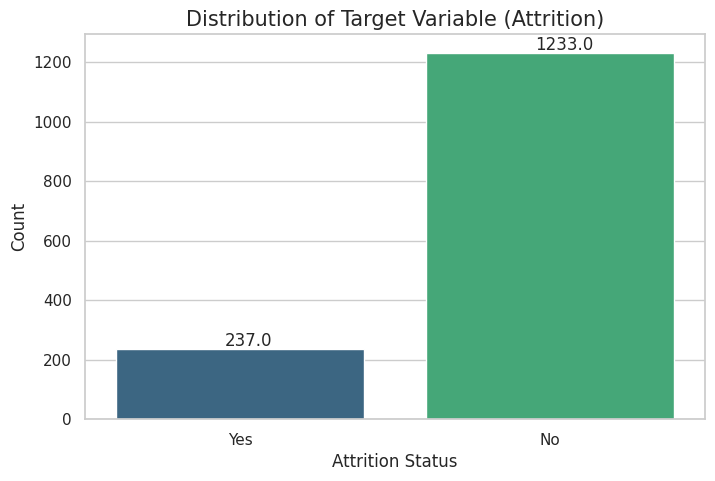

Insight: The severe imbalance (16% vs 84%) confirms we need synthetic data generation (SMOTE).
Saved to sidebar: correlation_heatmap.png


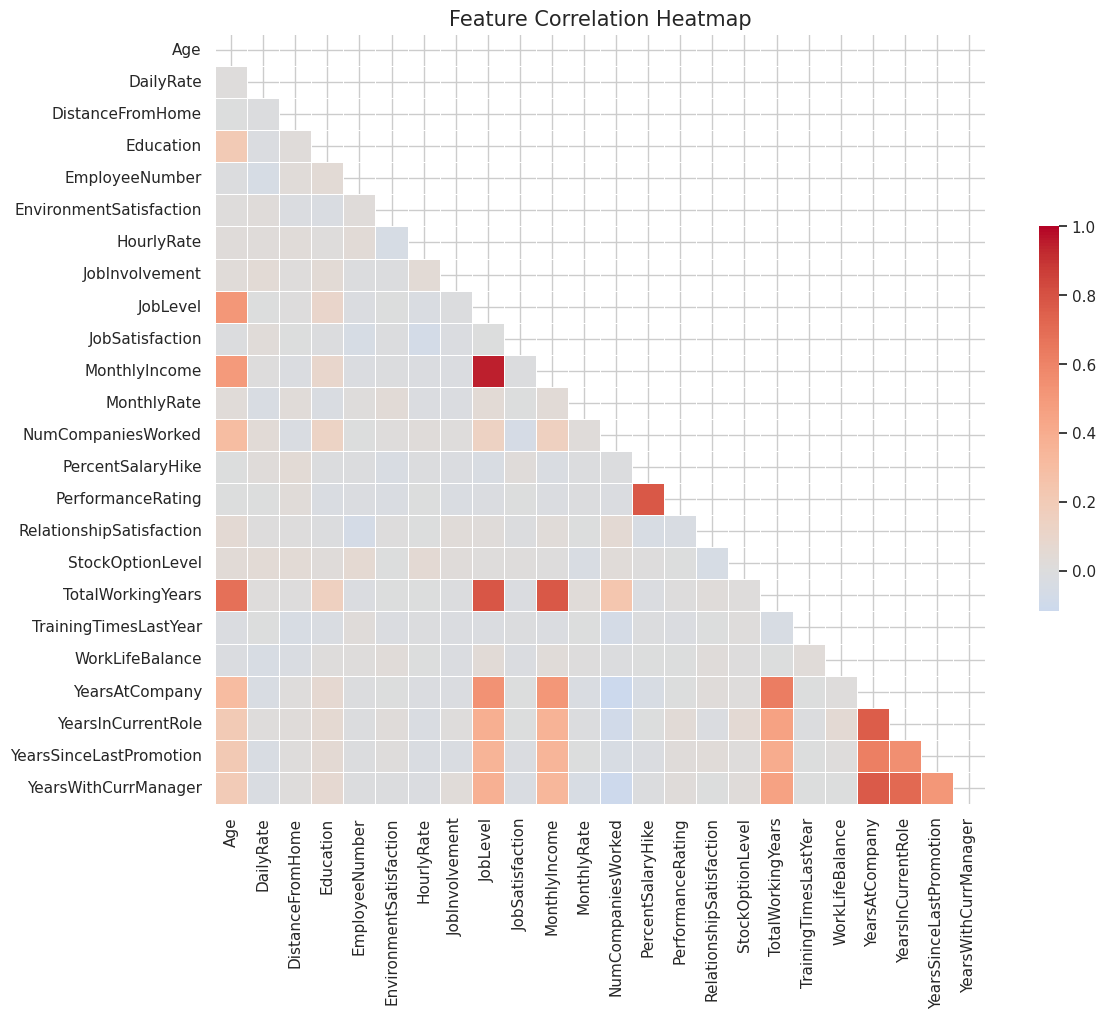

Insight: Darker red indicates strong positive correlation. This guides our feature selection strategy.


In [3]:
def plot_eda_charts(df):
    """
    Generates EDA charts to visualize data distribution and relationships.
    Saves high-res images to the Colab sidebar for PPT inclusion.
    """
    # Set visual style
    sns.set(style="whitegrid")

    # --- 1. Target Variable Distribution ---
    # Objective: Visualize Class Imbalance.
    # This chart proves to Member B why SMOTE is strictly necessary later.
    plt.figure(figsize=(8, 5))
    ax = sns.countplot(x='Attrition', data=df, palette='viridis')
    plt.title('Distribution of Target Variable (Attrition)', fontsize=15)
    plt.xlabel('Attrition Status')
    plt.ylabel('Count')

    # Add counts on top of bars for clarity
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + 0.35, p.get_height() + 10))

    # Save to local runtime disk (Sidebar)
    plt.savefig('attrition_distribution.png', dpi=300, bbox_inches='tight')
    print("Saved to sidebar: attrition_distribution.png")

    plt.show()
    print("Insight: The severe imbalance (16% vs 84%) confirms we need synthetic data generation (SMOTE).")

    # --- 2. Feature Correlation Heatmap ---
    # Objective: Identify Multicollinearity.
    # Helps us decide which features might be redundant (e.g., JobLevel vs MonthlyIncome).
    plt.figure(figsize=(14, 10))

    # Select numerical columns only
    numeric_df = df.select_dtypes(include=[np.number])
    corr = numeric_df.corr()

    # Mask the upper triangle to reduce visual clutter
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False)

    plt.title('Feature Correlation Heatmap', fontsize=15)

    # Save to local runtime disk (Sidebar)
    plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
    print("Saved to sidebar: correlation_heatmap.png")

    plt.show()
    print("Insight: Darker red indicates strong positive correlation. This guides our feature selection strategy.")

# Execute
plot_eda_charts(df)

## Section 3: Feature Engineering

This section details the construction of advanced metrics designed to capture **Individual Behavioral Patterns** and **Social Network Dynamics**.

### 1) Derived "Golden Features" (Individual Level)
We constructed four key features based on EDA insights to enhance the model's predictive power:

* **`Tenure_Ratio` (Loyalty)**: $\text{Tenure_Ratio} = \frac{\text{TotalWorkingYears}}{\text{NumCompaniesWorked}}$
    * **Logic:** Identifies "Job Hoppers" vs. loyal employees. A lower ratio suggests frequent switching.

* **`Income_Per_Age` (Fairness)**: $\text{Income_Per_Age} = \frac{\text{MonthlyIncome}}{\text{Age}}$
    * **Logic:** Highlights potential underpayment relative to age cohort. Low values may trigger attrition due to perceived unfairness.

* **`Burnout_Index` (Stress)**: $\text{Burnout_Index} = \frac{\text{PerformanceRating}}{\text{JobSatisfaction}}$
    * **Logic:** Captures high performers who are dissatisfied (**High Flight Risk**). High input (rating) but low output (satisfaction) equals burnout.

* **`Relative_Sat_to_Dept` (Isolation)**: $\text{Relative_Sat} = \text{JobSatisfaction} - \text{DeptMean(JobSatisfaction)}$
    * **Logic:** Measures the psychological gap compared to direct peers (**Relative Deprivation**). Being less satisfied than one's teammates is a strong predictor of leaving.

---

### 2) Organizational Network Analysis (Social Structural Level)
We constructed a synthetic **Homophily Graph** (using KNN on Scaled `Age`, `JobLevel`, and `Tenure` within Departments) to model the **"Attrition Contagion"** effect.

* **`Neighbor_Risk_Score` (Contagion):** The percentage of an employee's direct connections who have already left. This captures the "ripple effect" of turnover.
* **`PageRank_Score` (Influence):** Identifies informal leaders or central nodes whose departure might destabilize the entire team structure.
* **`Clustering_Coef` (Community):** Measures social tightness. High clustering coefficients suggest tight-knit groups that often act as "retention anchors."

### 3) Validation Strategy
* **Visual Validation:** Post-generation, we utilize **Boxplots** to verify that these new features show significant distribution differences between the `Attrition=Yes` and `Attrition=No` groups.

In [4]:
def create_derived_features(df):
    """
    Construct derived features based on EDA validation.
    Target: Enhance model predictive power by capturing proven behavioral patterns.
    """
    df_eng = df.copy()

    # ---------------------------------------------------------
    # 1. Tenure Ratio (Loyalty/Stability) - [Validated: Effective]
    # Formula: TotalWorkingYears / (NumCompaniesWorked + 1)
    # Logic: Calculates average tenure per employer.
    # Low values indicate a "Job Hopper" risk.
    # ---------------------------------------------------------
    df_eng['Tenure_Ratio'] = df_eng['TotalWorkingYears'] / (df_eng['NumCompaniesWorked'] + 1)

    # ---------------------------------------------------------
    # 2. Income Stability (Age-Adjusted Income) - [Validated: Strong Feature]
    # Formula: MonthlyIncome / Age
    # Logic: Normalizes income relative to age.
    # Identifies if an employee is underpaid compared to their age cohort.
    # ---------------------------------------------------------
    df_eng['Income_Per_Age'] = df_eng['MonthlyIncome'] / df_eng['Age']

    # ---------------------------------------------------------
    # 3. Burnout Index (High Performance / Low Satisfaction) - [New: Strongest Feature]
    # Formula: PerformanceRating / JobSatisfaction
    # Logic: Captures "Star Performers" who are unhappy.
    # High value = High Performance but Low Satisfaction (High Attrition Risk).
    # ---------------------------------------------------------
    if 'PerformanceRating' in df_eng.columns and 'JobSatisfaction' in df_eng.columns:
        df_eng['Burnout_Index'] = df_eng['PerformanceRating'] / df_eng['JobSatisfaction']

    # ---------------------------------------------------------
    # 4. Relative Satisfaction (Peer Comparison) - [New: Strong Feature]
    # Formula: Individual JobSatisfaction - Department Average
    # Logic: Measures if an employee is happier or sadder than their direct peers.
    # Negative value = "I hate it here, but everyone else seems fine" (Isolation).
    # ---------------------------------------------------------
    if 'Department' in df_eng.columns and 'JobSatisfaction' in df_eng.columns:
        # Calculate mean satisfaction per department
        dept_means = df_eng.groupby('Department')['JobSatisfaction'].transform('mean')
        df_eng['Relative_Sat_to_Dept'] = df_eng['JobSatisfaction'] - dept_means

    # ---------------------------------------------------------
    # Cleanup: Remove the ineffective feature if it exists
    # ---------------------------------------------------------
    if 'Satisfaction_Gap' in df_eng.columns:
        df_eng.drop('Satisfaction_Gap', axis=1, inplace=True)
        print("Note: Removed 'Satisfaction_Gap' due to low predictive power.")

    print(f"Feature Engineering Complete.")
    print(f"Added/Retained: ['Tenure_Ratio', 'Income_Per_Age', 'Burnout_Index', 'Relative_Sat_to_Dept']")

    return df_eng

# Execution
df = create_derived_features(df)

# Check results
print(df[['Tenure_Ratio', 'Income_Per_Age', 'Burnout_Index', 'Relative_Sat_to_Dept']].head())

Feature Engineering Complete.
Added/Retained: ['Tenure_Ratio', 'Income_Per_Age', 'Burnout_Index', 'Relative_Sat_to_Dept']
   Tenure_Ratio  Income_Per_Age  Burnout_Index  Relative_Sat_to_Dept
0      0.888889      146.170732           0.75              1.248879
1      5.000000      104.693878           2.00             -0.726327
2      1.000000       56.486486           1.00              0.273673
3      4.000000       88.151515           1.00              0.273673
4      0.600000      128.444444           1.50             -0.726327


/tmp/ipython-input-1300383738.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-1300383738.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-1300383738.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-1300383738.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


 Chart saved to: final_features_validation.png


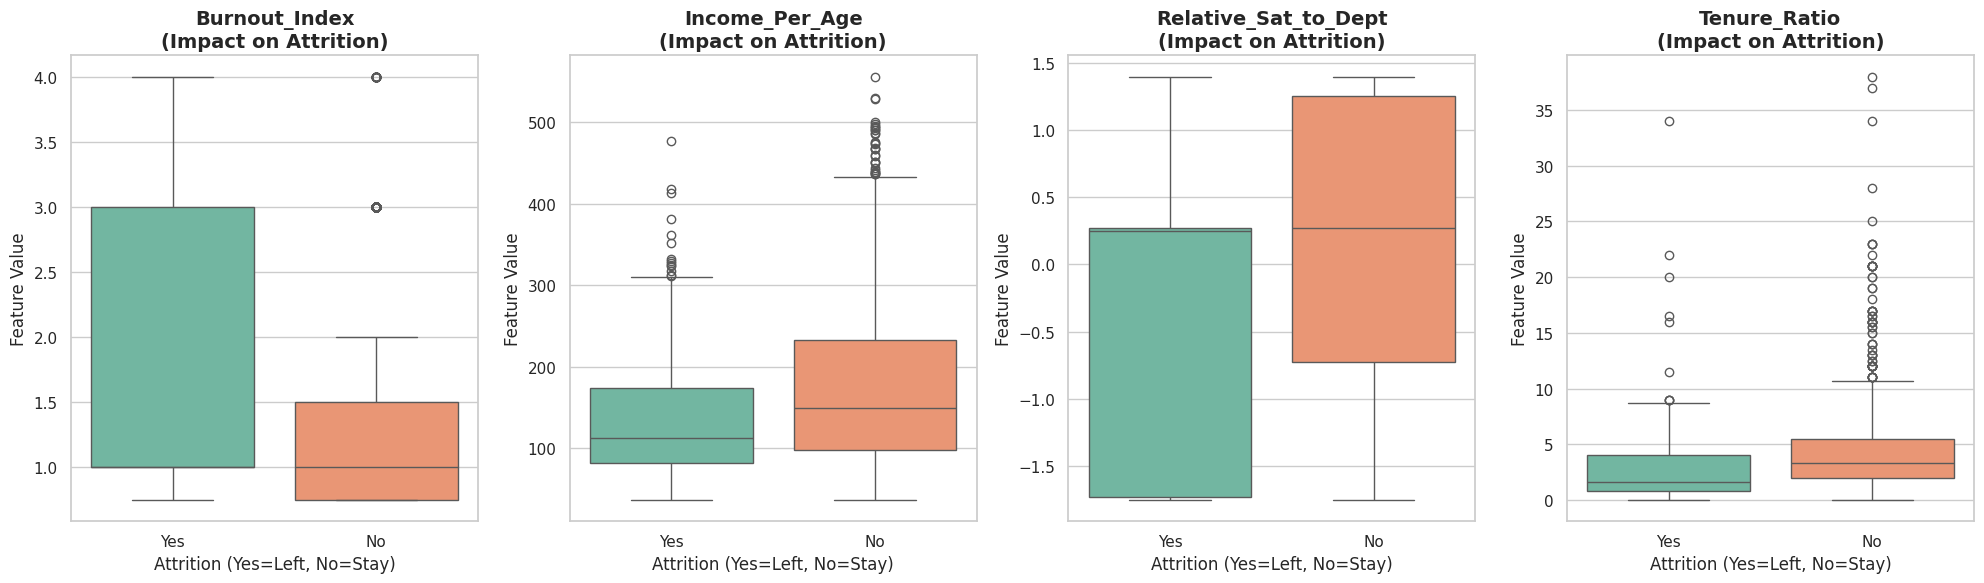

In [5]:
def plot_final_features_analysis(df):
    """
    Visualizes and analyzes the 4 identified "Golden Features" and saves the plot.
    """
    # Set plotting style
    sns.set(style="whitegrid")

    # Define the list of final features to analyze
    target_features = [
        'Burnout_Index',        # Burnout Index (Strongest predictor)
        'Income_Per_Age',       # Income Per Age (Very strong)
        'Relative_Sat_to_Dept', # Relative Satisfaction to Dept (Strong)
        'Tenure_Ratio'          # Tenure Ratio/Loyalty (Medium-Strong)
    ]

    # Filter out columns not present in the dataset (to prevent errors)
    valid_features = [col for col in target_features if col in df.columns]

    if not valid_features:
        print(" New features not found. Please run the 'create_derived_features' function first!")
        return

    # Create figure (1 row, N columns)
    fig, axes = plt.subplots(1, len(valid_features), figsize=(5 * len(valid_features), 6))

    # If there is only one feature, 'axes' is not a list; convert it for iteration
    if len(valid_features) == 1:
        axes = [axes]

    # Loop to plot boxplots
    for i, col in enumerate(valid_features):
        # Draw boxplot: visualize distribution, median, and outliers
        sns.boxplot(
            x='Attrition',
            y=col,
            data=df,
            ax=axes[i],
            palette='Set2',
            showfliers=True # Show outliers, this is important
        )

        # Set titles and labels
        axes[i].set_title(f'{col}\n(Impact on Attrition)', fontsize=14, fontweight='bold')
        axes[i].set_xlabel('Attrition (Yes=Left, No=Stay)')
        axes[i].set_ylabel('Feature Value')

    plt.tight_layout()

    # Save the figure
    filename = 'final_features_validation.png'
    plt.savefig(filename, dpi=300)
    print(f" Chart saved to: {filename}")

    plt.show()

# --- Run Visualization ---
plot_final_features_analysis(df)

## Section 4: Organizational Network Construction (Novelty)

This section details the engineering of a synthetic social graph to model **"Attrition Contagion"** and **Influence Dynamics** where no raw network data existed.

### 1) Network Topology Construction (Methodology)
We imposed specific constraints to simulate realistic information flow within the organization:

* **Hard Constraint (Departmental)**: $\text{Edge}(u, v) \iff \text{Dept}_u = \text{Dept}_v$
    * **Logic:** Employees primarily interact with peers in their own department. Edges are strictly restricted to intra-departmental connections.

* **Soft Constraint (Attribute Similarity)**: $\text{Weight}_{uv} = \text{KNN}(\text{Age, JobLevel, Tenure})$
    * **Logic:** Within departments, we use **K-Nearest Neighbors ($k=5$)** to link employees who share similar professional profiles.

* **Critical Feature Scaling**: $X_{\text{scaled}} = \frac{X - \mu}{\sigma}$ (StandardScaler)
    * **Logic:** Before KNN, we normalized features. Without scaling, large-magnitude variables (e.g., `Age` $\approx 40$) would dominate small-range variables (e.g., `JobLevel` $\approx 2$), distorting distance calculations.

---

### 2) Derived Network Metrics (Social Structural Level)
We calculated structural metrics to capture social dynamics and the contagion effect:

* **`Neighbor_Risk_Score` (Contagion)**: $\text{Risk}_i = \frac{\sum_{j \in \text{Neighbors}} \text{Attrition}_j}{\text{Total Neighbors}_i}$
    * **Logic:** Measures the "ripple effect" of turnover. The percentage of an employee's direct connections who have already left. If your closest peers leave, you are statistically more likely to leave.

* **`PageRank_Score` (Influence)**: $\text{PR}_i = \alpha \sum \frac{\text{PR}_j}{L_j} + \frac{1-\alpha}{N}$
    * **Logic:** Identifies "Informal Leaders" or central nodes. Their departure might destabilize the team structure. Visualized as **Node Size** in the graph.

* **`Clustering_Coef` (Community)**: $\text{Clustering}_i = \frac{2 \times \text{Triangles}_i}{\text{Degree}_i (\text{Degree}_i - 1)}$
    * **Logic:** Measures social tightness. High clustering coefficients suggest tight-knit cliques that often act as "retention anchors," making it harder for individuals to drift away.

### 3) Visualization Strategy
* **Force-Directed Graph**: We utilize a spring layout to visually validate natural clusters.
* **Visual Encoding**: **Node Color** represents Department; **Node Size** represents Influence (PageRank).

In [6]:
def build_organizational_network_final(df, n_neighbors=5):
    """
    Constructs the organizational network based on Homophily with Feature Scaling.

    Logic: Employees in the same department with similar Age, JobLevel, and Tenure
    are linked. Scaling is applied to ensure all features contribute equally.

    Ref: Project Outline Section 2 [Source: 18]
    """
    print("Building Organizational Network Graph (Final Version)...")
    G = nx.Graph()
    G.add_nodes_from(df['EmployeeNumber']) # Nodes are Employee IDs

    # 1. Feature Scaling (CRITICAL FIX)
    # Without scaling, Age (e.g., 40) dominates JobLevel (e.g., 2).
    # We use StandardScaler to put them on the same scale (mean=0, std=1).
    feature_cols = ['Age', 'TotalWorkingYears', 'JobLevel', 'YearsAtCompany']
    scaler = StandardScaler()

    # Create a temporary scaled dataframe to calculate distances
    # We do NOT overwrite the original df, as we need raw values later.
    df_scaled = df.copy()
    df_scaled[feature_cols] = scaler.fit_transform(df[feature_cols])

    # 2. Build Connections by Department
    departments = df['Department'].unique()

    for dept in departments:
        # Filter employees in the current department
        # We need both the scaled data (for KNN) and original IDs (for linking)
        dept_mask = df['Department'] == dept
        dept_data_scaled = df_scaled.loc[dept_mask, feature_cols]
        dept_employee_ids = df.loc[dept_mask, 'EmployeeNumber'].values

        # Skip if department is too small for KNN
        if len(dept_data_scaled) < n_neighbors:
            continue

        # 3. Run KNN
        knn = NearestNeighbors(n_neighbors=n_neighbors, metric='euclidean')
        knn.fit(dept_data_scaled)
        distances, indices = knn.kneighbors(dept_data_scaled)

        # 4. Add Edges
        for i in range(len(dept_data_scaled)):
            source_id = dept_employee_ids[i]

            # 'indices[i]' returns the index relative to the dept_data_scaled array
            for neighbor_idx in indices[i]:
                # Exclude self-loop
                if i != neighbor_idx:
                    target_id = dept_employee_ids[neighbor_idx]
                    G.add_edge(source_id, target_id)

    print(f" Network Built.")
    print(f"   - Nodes: {G.number_of_nodes()}")
    print(f"   - Edges: {G.number_of_edges()}")

    return G

def calculate_network_metrics_final(df, G):
    """
    Calculates network metrics including Influence, Contagion Risk, and Community Tightness.
    Merges these features back into the main DataFrame for the AI model.

    Ref: Project Outline Section 2 & 4 [Source: 80, 82, 85]
    """
    print("Calculating Network Metrics...")

    # --- A. Structural Metrics ---

    # 1. PageRank (Influence) [Source: 82]
    # Who are the "key players" or informal leaders?
    try:
        pagerank = nx.pagerank(G, alpha=0.85)
    except:
        pagerank = {n: 0 for n in G.nodes()}

    # 2. Clustering Coefficient (Community Tightness)
    # High value = "My friends are also friends with each other".
    # Harder to leave a tight clique.
    clustering = nx.clustering(G)

    # 3. Betweenness Centrality (Bridge Index) [Source: 83]
    # High value = Connects different groups.
    betweenness = nx.betweenness_centrality(G, k=100, seed=42)

    # 4. Degree Centrality (Popularity) [Source: 84]
    degree = nx.degree_centrality(G)

    # --- B. Contagion Metrics (The Novelty) ---

    # 5. Neighbor Risk Score (Attrition Contagion) [Source: 85]
    # Measures the percentage of direct friends who have already left.
    # Essential for the "Attrition Contagion" analysis.

    # Ensure Attrition is mapped to 0/1 for calculation
    # Handle cases where Attrition might still be 'Yes'/'No' or already numeric
    if df['Attrition'].dtype == 'object':
        attrition_map = df.set_index('EmployeeNumber')['Attrition'].map({'Yes': 1, 'No': 0}).to_dict()
    else:
        attrition_map = df.set_index('EmployeeNumber')['Attrition'].to_dict()

    neighbor_risk = {}
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        if len(neighbors) > 0:
            neighbor_vals = [attrition_map.get(n, 0) for n in neighbors]
            neighbor_risk[node] = sum(neighbor_vals) / len(neighbors)
        else:
            neighbor_risk[node] = 0.0

    # --- C. Isolation Metric ---

    # 6. Is_Isolated
    # Employees with no connections in the graph (high risk of leaving due to loneliness)
    is_isolated = {node: 1 if degree.get(node, 0) == 0 else 0 for node in G.nodes()}

    # --- Merge Everything ---

    metrics_df = pd.DataFrame({
        'EmployeeNumber': list(G.nodes()),
        'PageRank_Score': [pagerank.get(n, 0) for n in G.nodes()],
        'Betweenness_Score': [betweenness.get(n, 0) for n in G.nodes()],
        'Clustering_Coef': [clustering.get(n, 0) for n in G.nodes()],
        'Neighbor_Risk_Score': [neighbor_risk.get(n, 0) for n in G.nodes()],
        'Is_Isolated': [is_isolated.get(n, 0) for n in G.nodes()]
    })

    # Merge back to main dataframe
    df_final = pd.merge(df, metrics_df, on='EmployeeNumber', how='left')

    # Fill NaNs for any employees not in the graph (safety check)
    fill_cols = ['PageRank_Score', 'Betweenness_Score', 'Clustering_Coef', 'Neighbor_Risk_Score', 'Is_Isolated']
    df_final[fill_cols] = df_final[fill_cols].fillna(0)

    print(" Metrics merged successfully.")
    return df_final, G

# --- Execution ---
# 1. Build the network with Scaled Features
G = build_organizational_network_final(df)

# 2. Calculate Metrics (including Contagion Risk)
df_final, G = calculate_network_metrics_final(df, G)

# 3. Preview to verify 'Neighbor_Risk_Score' is present (Critical for Outline)
print(df_final[['EmployeeNumber', 'Neighbor_Risk_Score', 'Clustering_Coef', 'Attrition']].head())

Building Organizational Network Graph (Final Version)...
 Network Built.
   - Nodes: 1470
   - Edges: 3827
Calculating Network Metrics...
 Metrics merged successfully.
   EmployeeNumber  Neighbor_Risk_Score  Clustering_Coef Attrition
0               1             0.166667         0.533333       Yes
1               2             0.200000         0.300000        No
2               4             0.000000         0.500000       Yes
3               5             0.000000         0.833333        No
4               7             0.250000         0.666667        No


Generating Network Visualization (this may take a moment)...


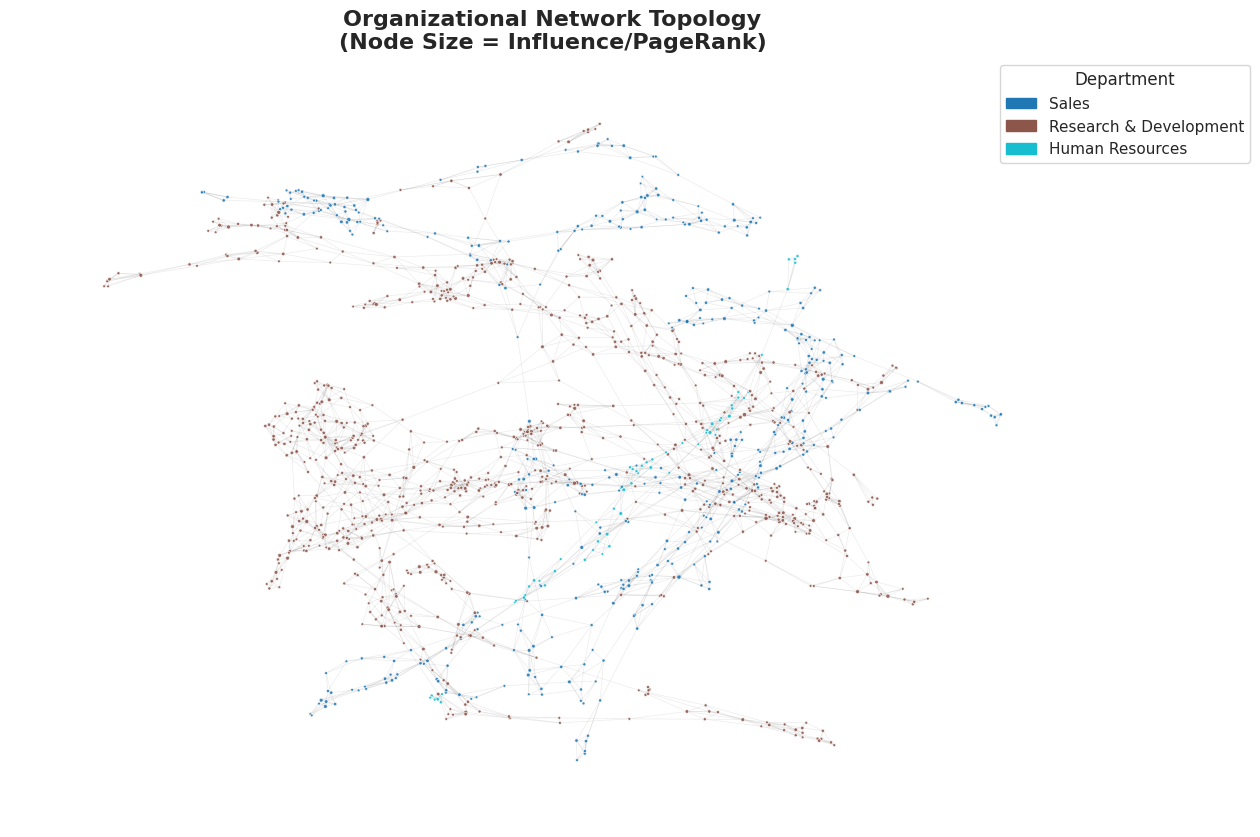

 Network Graph saved to: network_graph.png


In [7]:
def visualize_network_optimized(G, df_final, save_path='network_graph.png'):
    """
    Plots the Force-Directed Graph with optimized performance and aesthetics.
    """
    print("Generating Network Visualization (this may take a moment)...")
    plt.figure(figsize=(14, 10)) # Larger canvas

    # --- 1. Optimization: Create Mappings (O(1) lookup) ---
    pagerank_map = df_final.set_index('EmployeeNumber')['PageRank_Score'].to_dict()
    dept_series = df_final.set_index('EmployeeNumber')['Department']
    dept_map_raw = dept_series.to_dict()

    # Create color mapping for Departments
    unique_depts = dept_series.unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_depts)))
    dept_color_dict = dict(zip(unique_depts, colors))

    # --- 2. Prepare Drawing Lists ---
    node_sizes = [pagerank_map.get(n, 0) * 8000 for n in G.nodes()]
    node_colors = [dept_color_dict.get(dept_map_raw.get(n), 'grey') for n in G.nodes()]

    # --- 3. Layout Algorithm ---
    pos = nx.spring_layout(G, k=0.12, iterations=30, seed=42)

    # --- 4. Draw ---
    nx.draw_networkx_nodes(
        G, pos,
        node_size=node_sizes,
        node_color=node_colors,
        alpha=0.85,
        linewidths=0.5,
        edgecolors='white'
    )

    nx.draw_networkx_edges(
        G, pos,
        alpha=0.15,
        edge_color='gray',
        width=0.5
    )

    # --- 5. Add Legend ---
    legend_handles = [mpatches.Patch(color=color, label=dept) for dept, color in dept_color_dict.items()]
    plt.legend(handles=legend_handles, title="Department", loc='upper right', bbox_to_anchor=(1.15, 1))

    plt.title("Organizational Network Topology\n(Node Size = Influence/PageRank)", fontsize=16, fontweight='bold')
    plt.axis('off')

    # Save & Show
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f" Network Graph saved to: {save_path}")

visualize_network_optimized(G, df_final)

# 3. AI Model Design & Evaluation

**Author:**  **LYU JIZHOU**

This notebook covers **Phase 2** of the project: *AI Model Architect and Causal Inference*. The pipeline is divided into four core modules:

**Objective:**
Integrate network features (PageRank) with tabular features to build a high-accuracy employee attrition prediction model, using SMOTE and XGBoost, and provide explanations from both model performance and causal inference.

### Module 1: Feature Engineering & Data Balancing
* **Categorical Encoding:** Convert non-numeric features into a format acceptable by the model using Encoding Techniques.

* **Feature Integration:** Combine network features (e.g., PageRank scores, node degrees) with tabular features to provide the model with structural information about the organization.

* **Handling Imbalanced Data:** The proportion of employees who leave is approximately 16%, while those who stay account for 84%. Apply SMOTE (Synthetic Minority Oversampling Technique) to generate synthetic samples for the minority class, balancing the training set.

### Module 2: Model Construction
* **Model Choice:** Use XGBoost (Gradient Boosting Decision Tree) for its high accuracy and strong resistance to overfitting.

* **Model Training:** Feed the fused features into XGBoost for model training.

* **Parameter Selection & Fine-tuning:** Tune hyperparameters such as max_depth, learning_rate, and n_estimators to achieve optimal performance.

### Module 3: Model Evaluation & Performance
* **Precision / Recall / F1-score:** Focus on the accuracy of predicting the minority class.

* **Learning Curve:** Plot training vs validation error over sample size to detect underfitting or overfitting.

* **ROC Curve:** Evaluate classification performance, particularly the ability to detect the minority class.

* **Feature Impact:** Highlight top features contributing to model predictions.

### Module 4: Causal Analysis
* **Treatment & Outcome:** Select key features and outcome variables for causal estimation.

* **Causal Estimation:** Use DoWhy or CausalNex to compute Average Treatment Effect (ATE) or other causal metrics.

* **Interpretation:** Analyze the causal impact of selected features independently from model prediction.

In [8]:
# Install necessary libraries
!pip install imbalanced-learn
!pip install dowhy

## Module 1: Feature Engineering & Data Balancing

**Objective**
Prepare input features suitable for the model and handle class imbalance.

**Output**
Cleaned, encoded, and balanced training feature matrix and labels.

### Split Train / Test Before Encoding

**Prevent Data Leakage**

If you encode the entire dataset before splitting, information from the test set can leak into the training set. This causes overfitting and gives overly optimistic performance metrics.

**Ensure Independent Encoding**

Encoders should be fitted on the training set only. The test set should only use the rules derived from training to simulate real-world scenarios.

**Handle Unseen Categories**

Test data may contain categories not seen in training. Splitting first allows to properly handle unknown categories (e.g., unknown_value=-1 or handle_unknown='ignore').

### Data Scaling
**Not Necessary**
* Tree-based models are scale-invariant
  * Models like Decision Trees, Random Forest, and XGBoost do not rely on the magnitude of features.
  * Splits are based on feature order and thresholds, not absolute values.

* SMOTE works in feature space, not sensitive to scale for tree-based models
  * SMOTE generates synthetic samples by interpolating between minority class points.
  * Minor differences in scale do not impact splits for tree-based models.

* Avoid unnecessary preprocessing
  * Scaling adds computational cost and complexity.
  * Since your pipeline uses tree-based classifiers, scaling does not bring benefits.

* Feature importance ranking remains valid
  * Tree-based models compute feature importance based on how much a feature reduces impurity (e.g., Gini, entropy).
  * Scaling the features does not change the order of feature importance, so relative ranking remains the same.

**Summary**
* For tree-based models, scaling is unnecessary because splits depend on thresholds, SMOTE works directly, and feature importance ranking is unaffected by feature magnitude.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder


def advanced_data_processing(df):
  """
  Advanced Data Preprocessing Pipeline for Employee Attrition Prediction

  This function implements a complete and leakage-safe data preprocessing pipeline to prepare structured data for machine learning models.

  Steps:
    1. Drop irrelevant columns
    2. Split features and target
    3. Split train/test sets
    4. Encode categorical variables
      - Ordinal Encoding
      - One-Hot Encoding
      - Frequency Encoding
      - Binary Encoding
    5. Return processed train/test sets
  """


  # ---------------------------------------------------------
  # 1. Drop irrelevant columns


  # Columns that do not help predict employee attrition and may introduce noise.
  # EmployeeNumber is a unique identifier with no predictive value

  columns_to_drop = ['EmployeeNumber']
  df_clean = df.drop(columns=columns_to_drop)


  # ---------------------------------------------------------
  # 2. Split features and target


  # Attrition is the target column (Yes/No)
  X = df_clean.drop(columns=['Attrition'])
  y = df_clean['Attrition']
  print(f"Features shape: {X.shape}")
  print(f"Target distribution: {y.value_counts().to_dict()}")


  # ---------------------------------------------------------
  # 3. Split train/test sets


  X_train, X_test, y_train, y_test = train_test_split(
      X,
      y,
      test_size=0.2,
      random_state=42,  # For reproducibility
      stratify=y  # stratify=y ensures the same target distribution in train/test
  )


  # ---------------------------------------------------------
  # 4. Encode variable


  # 4.1 Label Encoding
  # BusinessTravel has an obvious hierarchy, code the ordered features to preserve the rank information
  if 'BusinessTravel' in X_train.columns:
    travel_order = [["Non-Travel", "Travel_Rarely", "Travel_Frequently"]]
    le_enc = OrdinalEncoder(categories=travel_order,
                            handle_unknown="use_encoded_value",
                            unknown_value=-1)
    # Fit only on training data to prevent data leakage
    le_enc.fit(X_train[["BusinessTravel"]])

    # Transform both train and test
    X_train["BusinessTravel_label"] = le_enc.transform(
        X_train[["BusinessTravel"]])
    X_test["BusinessTravel_label"] = le_enc.transform(X_test[["BusinessTravel"]])

  # 4.2 One-Hot Encoding
  # One-Hot keeps each category as a separate feature. Department and MaritalStatus are unordered categorical variables
  onehot_features = ["Department", "MaritalStatus"]
  if onehot_features:
    onehot_enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop=None)

    onehot_enc.fit(X_train[onehot_features])
    # Transform both sets
    train_oh = onehot_enc.transform(X_train[onehot_features])
    test_oh = onehot_enc.transform(X_test[onehot_features])
    # Get feature names for one-hot encoded columns
    oh_cols = onehot_enc.get_feature_names_out(onehot_features)

    # Convert numpy arrays to DataFrame, keep original index
    X_train_oh = pd.DataFrame(train_oh, columns=oh_cols, index=X_train.index)
    X_test_oh = pd.DataFrame(test_oh, columns=oh_cols, index=X_test.index)
    # Concatenate one-hot encoded columns with original DataFrame
    X_train = pd.concat([X_train, X_train_oh], axis=1)
    X_test = pd.concat([X_test, X_test_oh], axis=1)

  # 4.3 Frequency Encoding
  # EducationField and JobRole may have many categories, use frequency as replacement
  if 'EducationField' in X_train.columns:
    freq_enc = X_train["EducationField"].value_counts(normalize=True)

    X_train["EducationField_freq"] = X_train["EducationField"].map(freq_enc)
    X_test["EducationField_freq"] = X_test["EducationField"].map(
        freq_enc).fillna(0)

  if 'JobRole' in X_train.columns:
    jobrole_freq = X_train["JobRole"].value_counts(normalize=True)

    X_train["JobRole_freq"] = X_train["JobRole"].map(jobrole_freq)
    X_test["JobRole_freq"] = X_test["JobRole"].map(jobrole_freq).fillna(0)

  # 4.4 Binary Encoding
  # Gender and OverTime are binary, map to 0/1 instead of strings
  if 'Gender' in X_train.columns:
    gender_binary_map = {"Male": 1, "Female": 0}

    X_train["Gender_bin"] = X_train["Gender"].map(gender_binary_map)
    X_test["Gender_bin"] = X_test["Gender"].map(gender_binary_map)

  if 'OverTime' in X_train.columns:
    overtime_binary_map = {"Yes": 1, "No": 0}

    X_train["OverTime_bin"] = X_train["OverTime"].map(overtime_binary_map)
    X_test["OverTime_bin"] = X_test["OverTime"].map(overtime_binary_map)

  # 4.5 Encode Target Variable

  # Label the Attrition column, converting 'Yes'/'No' to 1/0
  attrition_binary_map = {"Yes": 1, "No": 0}

  y_train = y_train.map(attrition_binary_map)
  y_test = y_test.map(attrition_binary_map)


  # ---------------------------------------------------------
  # 5. Drop original categorical columns.


  # Remove original categorical columns after encoding
  # Keep only processed encoded features.
  columns_to_drop_after_encoding = [
      "BusinessTravel", "Department", "MaritalStatus", "EducationField",
      "JobRole", "Gender", "OverTime"
  ]
  # Also drop engineered features that were removed in original code
  # optional_drops = [
  #     'Betweenness_Score', 'Clustering_Coef', 'Neighbor_Risk_Score',
  #     'Is_Isolated', 'Tenure_Ratio', 'Income_Per_Age', 'Burnout_Index',
  #     'Relative_Sat_to_Dept'
  #]
  # Drop only if they exist
  columns_to_drop_final = [
      col for col in columns_to_drop_after_encoding
      if col in X_train.columns
  ]

  X_train = X_train.drop(columns=columns_to_drop_final, errors='ignore')
  X_test = X_test.drop(columns=columns_to_drop_final, errors='ignore')

  # Check for any remaining missing values
  train_missing = X_train.isnull().sum().sum()
  test_missing = X_test.isnull().sum().sum()
  if train_missing > 0 or test_missing > 0:
    print(f"Warning: Found {train_missing} missing values in train, "
          f"{test_missing} in test")
  else:
    print("No missing values detected")

  # Return processed train/test features and target
  return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = advanced_data_processing(df_final)

Features shape: (1470, 39)
Target distribution: {'No': 1233, 'Yes': 237}
No missing values detected


### SMOTE

**SMOTE (Synthetic Minority Over-sampling Technique)** is a technique used to address class imbalance in datasets, especially for classification problems where one class (minority class) has far fewer samples than the other (majority class).

**Key Points / How it Works:**

* Generate Synthetic Samples:
  * Instead of simply duplicating minority class samples, SMOTE creates new synthetic samples by interpolating between existing minority class points.
  * This helps the model learn a more general decision boundary.

* Nearest Neighbors:
  * For each minority sample, SMOTE selects k nearest neighbors in feature space.
  * New samples are generated along the line connecting the sample to its neighbors.

* Balance the Dataset:
  * After SMOTE, the dataset has a roughly equal number of samples in each class, reducing bias toward the majority class.

* Improves Model Performance:
  * Helps classifiers (like logistic regression, decision trees, XGBoost) better recognize minority class patterns.
  * Reduces false negatives for rare events.

**Caveats:**
* SMOTE can introduce noise if minority class has outliers.
* Best used after train/test split to prevent data leakage.

**Summary:**
* SMOTE synthetically balances the dataset, creating new minority samples based on neighbors, improving classifier performance for imbalanced datasets.

Training set distribution before SMOTE: [986 190]
Training set distribution after SMOTE: [986 986]


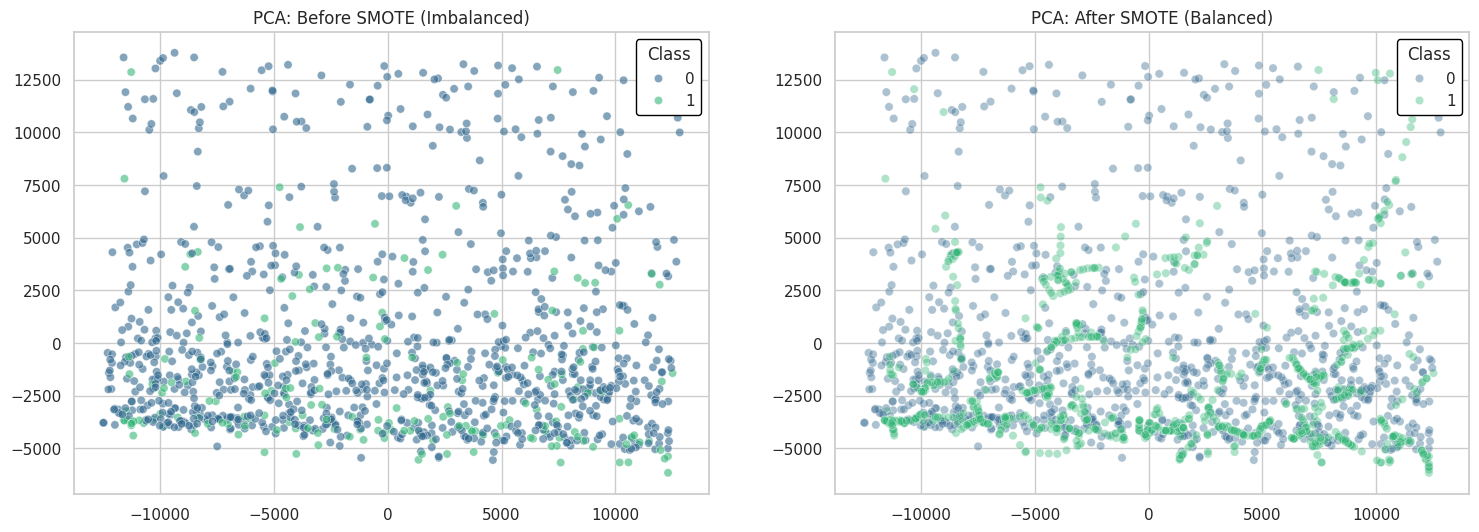

In [10]:
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA


def advanced_data_smote(X_train, y_train):
  """
  SMOTE-based Class Imbalance Handling and Visualization

  This function addresses the severe class imbalance problem in the employee attrition dataset by combining exploratory visualization, SMOTE resampling, and PCA-based distribution analysis.

  Steps:
    1. Apply SMOTE to generate synthetic samples for minority class
    2. PCA visualization for distribution check before and after SMOTE
  """

  # ---------------------------------------------------------
  # 1. Check class distribution before SMOTE
  print(
      f"Training set distribution before SMOTE: {np.bincount(y_train)}"
  )  # np.bincount counts the number of occurrences of each integer class label

  # ---------------------------------------------------------
  # 2. Initialize SMOTE
  smote = SMOTE(
      random_state=42,  # random_state=42: ensure reproducibility
      k_neighbors=
      3  # k_neighbors=3: number of nearest neighbors used for synthetic sample generation
  )

  # ---------------------------------------------------------
  # 3. Apply SMOTE to handle class imbalance
  X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
  # Check class distribution after SMOTE
  print(f"Training set distribution after SMOTE: {np.bincount(y_resampled)}")

  # ---------------------------------------------------------
  # 4. PCA visualization for distribution check
  # Reduce features to 2 dimensions for scatter plot
  pca = PCA(n_components=2)
  pca.fit(X_train)  # Fit PCA on original training set only
  X_vis_before = pca.transform(X_train)  # Transform original imbalanced data
  X_vis_after = pca.transform(X_resampled)  # Transform SMOTE-balanced data

  # ---------------------------------------------------------
  # 5. Create side-by-side scatter plots
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
  # Left plot: before SMOTE
  sns.scatterplot(x=X_vis_before[:, 0],
                  y=X_vis_before[:, 1],
                  hue=y_train,
                  ax=ax1,
                  palette='viridis',
                  alpha=0.6)
  ax1.set_title("PCA: Before SMOTE (Imbalanced)")
  ax1.legend(title='Class',
             loc='upper right',
             frameon=True,
             facecolor='white',
             edgecolor='black',
             framealpha=1.0)

  # Right plot: after SMOTE
  sns.scatterplot(x=X_vis_after[:, 0],
                  y=X_vis_after[:, 1],
                  hue=y_resampled,
                  ax=ax2,
                  palette='viridis',
                  alpha=0.4)
  ax2.set_title("PCA: After SMOTE (Balanced)")
  ax2.legend(title='Class',
             loc='upper right',
             frameon=True,
             facecolor='white',
             edgecolor='black',
             framealpha=1.0)

  # Show plots
  plt.show()

  # Return resampled dataset
  return X_resampled, y_resampled


X_train, y_train = advanced_data_smote(X_train, y_train)

## Module 2: Model Construction

**Objective** Define and explore the hyperparameter space to construct a robust and effective model.  

**Output** Includes the best hyperparameters found and the corresponding validation performance, which can be used to train the final model.

### Hyperparameter Optimization for XGBoost using Optuna

In binary classification problems, XGBoost is a powerful non-linear model that often achieves high predictive performance. However, its performance is highly sensitive to hyperparameters such as tree depth, learning rate, number of trees, gamma, and subsample ratios.  

Manual tuning of these parameters can be time-consuming, inefficient, and prone to suboptimal results.
To address this, project uses **Optuna**, an automated hyperparameter optimization framework that efficiently searches for the best combination of parameters.

* Systematic exploration of the hyperparameter space.
* Robust model evaluation using Stratified K-Fold cross-validation to maintain class balance in each fold.
* Optimization of a meaningful performance metric, in this case, **AUC (Area Under the ROC Curve)**.
* Reduction of human bias and trial-and-error in hyperparameter selection, leading to improved model performance and stability.

**Workflow**
  1. Run Optuna optimization to explore hyperparameter space
  2. Extract trial history (learning_rate, max_depth, AUC)
  3. Create heatmap showing performance landscape
  4. Identify optimal parameter region visually

**Key Hyperparameters**
* **Learning Rate**: Step size at each iteration
* **Max Depth**: Maximum tree depth

In [11]:
# Hyperparameter Tuning Based on Optuna Optimization
!pip install optuna
import optuna
import warnings

from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from scipy.interpolate import griddata

optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings('ignore')

# Set professional visualization style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = '#f8f9fa'


# ---------------------------------------------------------
# 1. Optuna Hyperparameter Optimization


def objective(trial, X_train, y_train):
  """
  XGBoost Hyperparameter Optimization with Optuna

  This script performs automated hyperparameter tuning for an XGBoost binary classification model using Optuna. It evaluates model performance using Stratified K-Fold cross-validation and optimizes the area under the ROC curve (AUC).

  Steps:
    1. Define the hyperparameter search space for XGBoost, including tree depth, learning rate, number of trees, gamma, subsample ratio, and feature subsample ratio.
    2. Initialize the XGBoost classifier with trial-suggested parameters.
    3. Perform 5-fold Stratified K-Fold cross-validation to ensure balanced class distributions in each fold.
    4. Calculate the AUC for each fold and return 1 - mean(AUC) as the objective function for Optuna to minimize.
    5. Run Optuna study to search for the optimal hyperparameters.
    6. Output the best hyperparameter combination and the corresponding AUC score.
  """

  # Define hyperparameter search space
  param = {
      'objective':
      'binary:logistic',
      'eval_metric':
      'auc',
      'max_depth':
      trial.suggest_int('max_depth', 3, 20),
      'learning_rate':
      trial.suggest_float('learning_rate', 0.01, 0.3),
      'n_estimators':
      trial.suggest_int('n_estimators', 100, 1000),
      'gamma':
      trial.suggest_float('gamma', 1e-8, 1.0),
      'subsample':
      trial.suggest_float('subsample', 0.6, 1.0, step=0.1),
      'colsample_bytree':
      trial.suggest_float('colsample_bytree', 0.6, 1.0, step=0.1),
      'random_state':
      7,
      'use_label_encoder':
      False,
      'n_jobs':
      -1,
      'verbosity':
      0
  }

  # Initialize XGBoost classifier
  xgb = XGBClassifier(**param)

  # Stratified K-Fold cross-validation
  cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

  # Evaluate using cross_val_score with AUC
  scores = cross_val_score(xgb,
                           X_train,
                           y_train,
                           cv=cv,
                           scoring='roc_auc',
                           n_jobs=-1)

  # Return 1 - mean(AUC) as objective to minimize
  return 1 - scores.mean()


def run_optuna_optimization(X_train,
                            y_train,
                            n_trials=100,
                            show_progress=True):
  """
    Run Optuna hyperparameter optimization.

    Parameters:
    -----------
    X_train : array-like
        Training features
    y_train : array-like
        Training target
    n_trials : int
        Number of optimization trials
    show_progress : bool
        Whether to show progress bar

    Returns:
    --------
    optuna.Study : Completed Optuna study object
    """

  print("OPTUNA HYPERPARAMETER OPTIMIZATION")
  print(f"\nConfiguration:")
  print(f"  Number of trials: {n_trials}")
  print(f"  Cross-validation: 5-fold Stratified")
  print(f"  Objective: Maximize AUC")
  print(f"  Search space:")
  print(f"    - Learning Rate: [0.01, 0.30]")
  print(f"    - Max Depth: [3, 20]")
  print(f"    - N Estimators: [100, 1000]")
  print(f"    - Gamma: [1e-8, 1.0]")
  print(f"    - Subsample: [0.6, 1.0]")
  print(f"    - Colsample by Tree: [0.6, 1.0]")
  print("\n" + "-" * 70)
  print("Starting optimization...\n")

  # Create Optuna study
  study = optuna.create_study(direction='minimize',
                              study_name='xgboost_optimization')

  # Run optimization with progress bar
  study.optimize(lambda trial: objective(trial, X_train, y_train),
                 n_trials=n_trials,
                 show_progress_bar=show_progress)

  # Output best parameters
  best_params = study.best_params
  best_score = 1 - study.best_value

  print("-" * 70)
  print("OPTIMIZATION COMPLETED")
  print("\nBest Hyperparameters Found:")
  for key, value in best_params.items():
    if isinstance(value, float):
      print(f"  {key:20s}: {value:.6f}")
    else:
      print(f"  {key:20s}: {value}")
  print()
  print(f"  Best AUC Score:     {best_score:.6f}")
  print("-" * 70)

  return study


# ---------------------------------------------------------
# 2. Extract Trial Data for Visualization


def extract_trial_data(study):
  """
  Extract learning_rate, max_depth, and AUC from Optuna trials.
  """

  trials_data = []

  for trial in study.trials:
    # Only include completed trials
    if trial.state == optuna.trial.TrialState.COMPLETE:
      trials_data.append({
          'trial_number':
          trial.number,
          'learning_rate':
          trial.params.get('learning_rate'),
          'max_depth':
          trial.params.get('max_depth'),
          'n_estimators':
          trial.params.get('n_estimators'),
          'gamma':
          trial.params.get('gamma'),
          'subsample':
          trial.params.get('subsample'),
          'colsample_bytree':
          trial.params.get('colsample_bytree'),
          'auc':
          1 - trial.value  # Convert back to AUC
      })

  df = pd.DataFrame(trials_data)

  print(f"Extracted {len(df)} completed trials")
  print(f"AUC range: [{df['auc'].min():.4f}, {df['auc'].max():.4f}]")

  return df


def optuna_hperparameter_optimization(X_train, y_train, n_trials=100):
  # Step 1: Run Optuna optimization
  study = run_optuna_optimization(X_train, y_train, n_trials=n_trials)

  # Step 2: Extract trial data
  trials_df = extract_trial_data(study)

  return study, trials_df


study, trials_df = optuna_hperparameter_optimization(X_train, y_train)

OPTUNA HYPERPARAMETER OPTIMIZATION

Configuration:
  Number of trials: 100
  Cross-validation: 5-fold Stratified
  Objective: Maximize AUC
  Search space:
    - Learning Rate: [0.01, 0.30]
    - Max Depth: [3, 20]
    - N Estimators: [100, 1000]
    - Gamma: [1e-8, 1.0]
    - Subsample: [0.6, 1.0]
    - Colsample by Tree: [0.6, 1.0]

----------------------------------------------------------------------
Starting optimization...



  0%|          | 0/100 [00:00<?, ?it/s]

----------------------------------------------------------------------
OPTIMIZATION COMPLETED

Best Hyperparameters Found:
  max_depth           : 10
  learning_rate       : 0.028106
  n_estimators        : 659
  gamma               : 0.031028
  subsample           : 0.700000
  colsample_bytree    : 0.800000

  Best AUC Score:     0.977363
----------------------------------------------------------------------
Extracted 100 completed trials
AUC range: [0.9692, 0.9774]


### Hyperparameter Optimization Analysis and Visualization

Provides a comprehensive post-hoc analysis and visualization framework for hyperparameter optimization conducted with Optuna.
It aims to systematically examine both the global structure of the hyperparameter search space and the local behavior of individual optimization trials.

* A two-dimensional heatmap is constructed to illustrate the relationship between the learning rate, maximum tree depth, and the cross-validated AUC score.

  The hyperparameter space is discretized into bins, and the mean AUC within each bin is computed, enabling the identification of parameter regions that exhibit consistently strong performance rather than relying on isolated optimal trials.

  The best-performing Optuna trial is explicitly highlighted to facilitate direct comparison between region-level trends and point-wise optimality.

* A smooth performance landscape is generated using scattered trial results and cubic interpolation.
  This contour-based visualization captures the continuous variation of model performance across the hyperparameter space, providing an intuitive understanding of sensitivity and interaction effects between learning rate and tree depth.
  The actual Optuna trials and the globally optimal configuration are overlaid to preserve the connection between interpolated estimates and observed evaluations.

* The optimization dynamics are analyzed by visualizing the evolution of AUC scores across trials and estimating the relative importance of individual hyperparameters.
  The optimization history reveals convergence behavior and performance stability, while the parameter importance analysis offers insights into which hyperparameters most strongly influence model performance.


Creating hyperparameter heatmap...


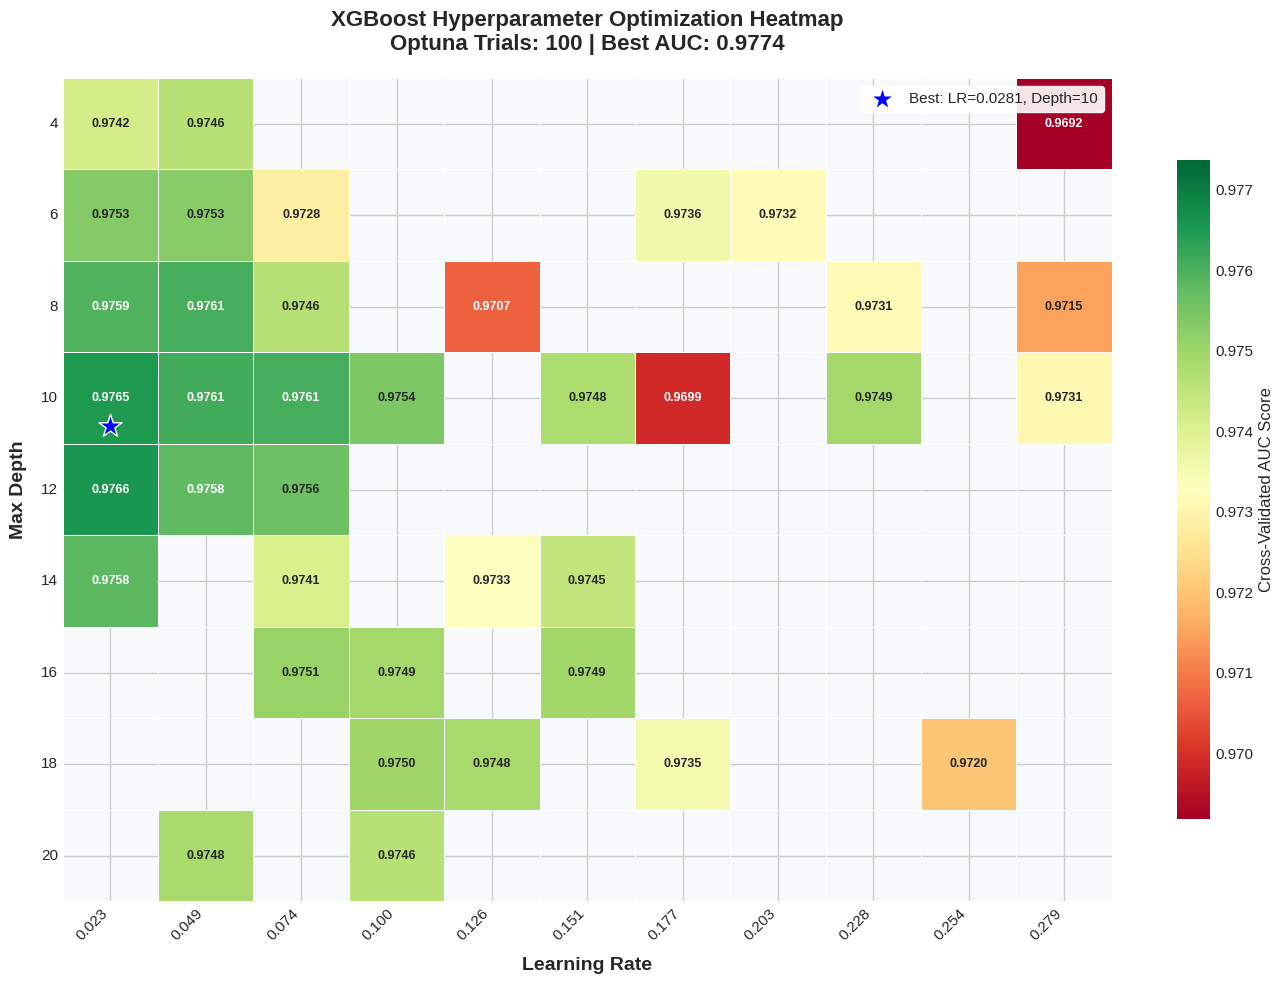


Creating performance landscape...


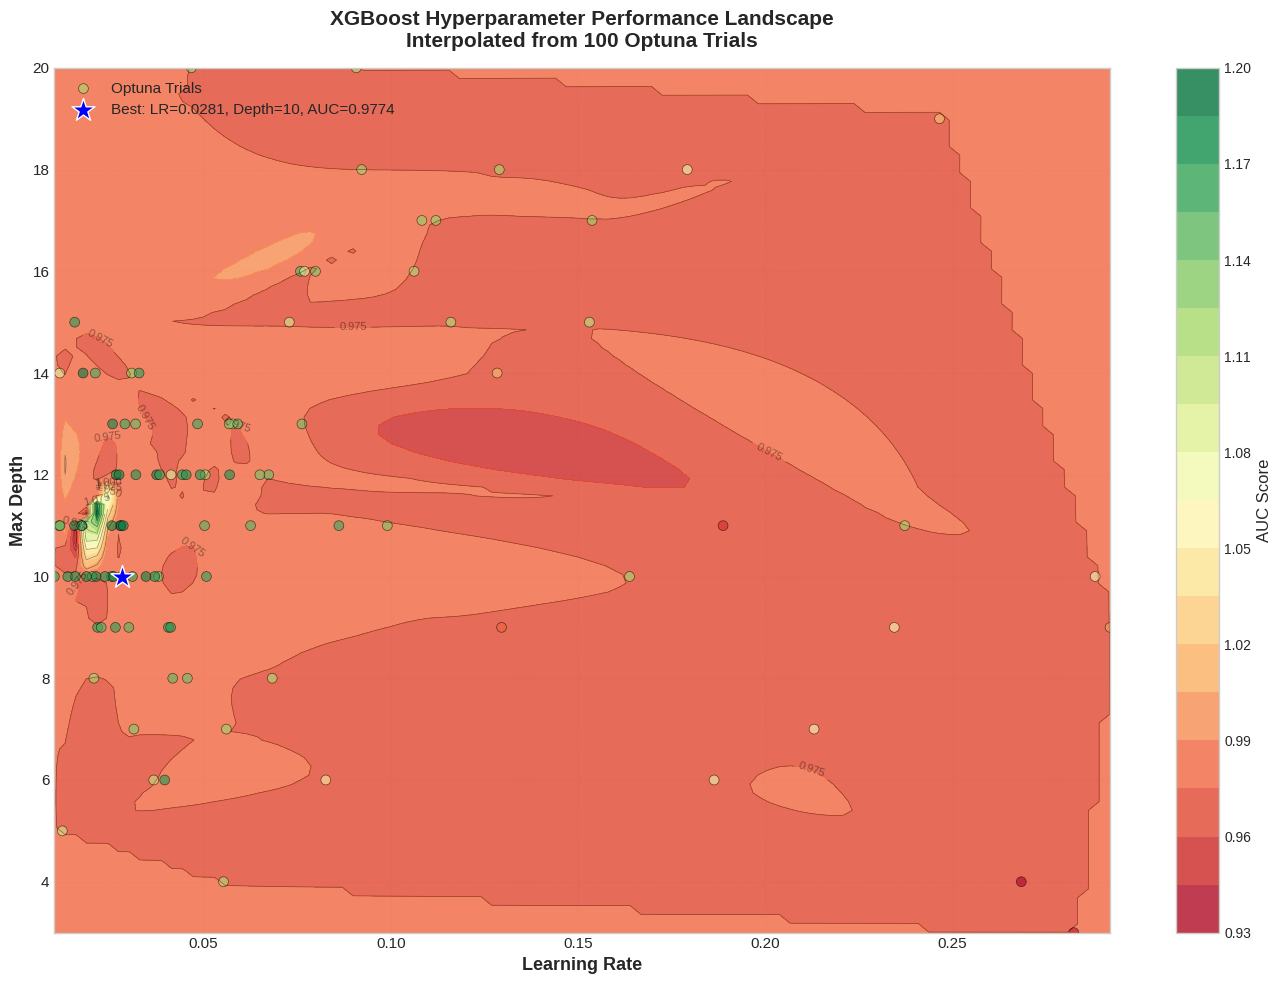


Creating optimization history...


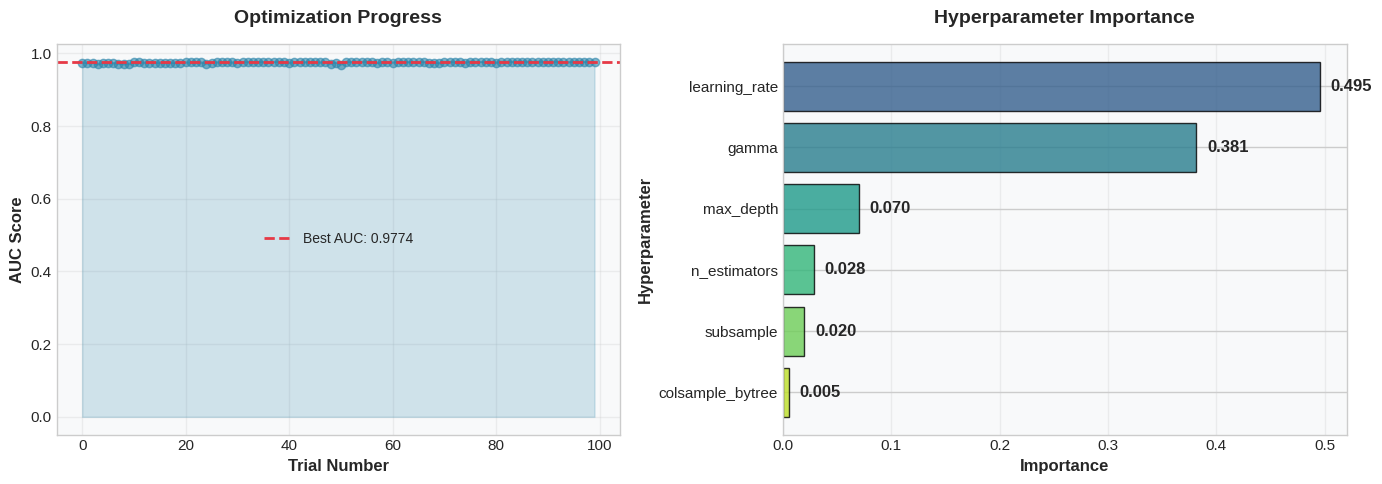

In [12]:
# Hyperparameter Optimization Analysis and Visualization


# ---------------------------------------------------------
# 1. Create Hyperparameter Heatmap


def plot_hyperparameter_heatmap(trials_df, study, figsize=(14, 10)):
  """
  Create heatmap showing relationship between learning_rate, max_depth, and AUC.
  """

  # Create grid for heatmap
  lr_bins = np.linspace(trials_df['learning_rate'].min(),
                        trials_df['learning_rate'].max(), 12)
  depth_bins = np.arange(trials_df['max_depth'].min(),
                         trials_df['max_depth'].max() + 2, 2)

  # Bin the data and compute mean AUC for each cell
  trials_df['lr_bin'] = pd.cut(trials_df['learning_rate'], bins=lr_bins)
  trials_df['depth_bin'] = pd.cut(trials_df['max_depth'], bins=depth_bins)

  # Aggregate by taking mean AUC in each bin
  heatmap_data = trials_df.groupby(['depth_bin',
                                    'lr_bin'])['auc'].mean().unstack()

  # Get bin centers for labels
  lr_labels = [(interval.left + interval.right) / 2
               for interval in heatmap_data.columns]
  depth_labels = [(interval.left + interval.right) / 2
                  for interval in heatmap_data.index]

  # Create figure
  fig, ax = plt.subplots(figsize=figsize)

  # Create heatmap
  sns.heatmap(heatmap_data,
              annot=True,
              fmt='.4f',
              cmap='RdYlGn',
              cbar_kws={
                  'label': 'Cross-Validated AUC Score',
                  'shrink': 0.8
              },
              linewidths=0.5,
              linecolor='white',
              square=False,
              vmin=trials_df['auc'].min(),
              vmax=trials_df['auc'].max(),
              ax=ax,
              annot_kws={
                  'size': 9,
                  'weight': 'bold'
              })

  # Customize labels
  ax.set_xticklabels([f'{x:.3f}' for x in lr_labels], rotation=45, ha='right')
  ax.set_yticklabels([f'{int(y)}' for y in depth_labels], rotation=0)

  ax.set_xlabel('Learning Rate', fontsize=14, fontweight='bold', labelpad=10)
  ax.set_ylabel('Max Depth', fontsize=14, fontweight='bold', labelpad=10)
  ax.set_title(
      f'XGBoost Hyperparameter Optimization Heatmap\n'
      f'Optuna Trials: {len(trials_df)} | Best AUC: {trials_df["auc"].max():.4f}',
      fontsize=16,
      fontweight='bold',
      pad=20)

  # Mark best trial
  best_trial = study.best_trial
  best_lr = best_trial.params['learning_rate']
  best_depth = best_trial.params['max_depth']

  # Find closest bin position
  lr_bin_idx = np.digitize(best_lr, lr_bins) - 1
  depth_bin_idx = np.digitize(best_depth, depth_bins) - 1

  # Add star marker
  ax.scatter(lr_bin_idx + 0.5,
             depth_bin_idx + 0.8,
             marker='*',
             s=300,
             c='blue',
             edgecolors='white',
             linewidths=1,
             label=f'Best: LR={best_lr:.4f}, Depth={best_depth}',
             zorder=10)

  ax.legend(loc='upper right',
            frameon=True,
            facecolor='white',
            edgecolor='white',
            framealpha=0.9)

  plt.tight_layout()
  plt.show()

  return fig


# ---------------------------------------------------------
# 2. Create Scatter Plot with Interpolation


def plot_scatter_with_interpolation(trials_df, study, figsize=(14, 10)):
  """
  Create interpolated contour plot showing smooth performance landscape.
  """

  # Extract data
  lr = trials_df['learning_rate'].values
  depth = trials_df['max_depth'].values
  auc = trials_df['auc'].values

  # Create fine grid for interpolation
  lr_grid = np.linspace(lr.min(), lr.max(), 100)
  depth_grid = np.linspace(depth.min(), depth.max(), 100)
  lr_mesh, depth_mesh = np.meshgrid(lr_grid, depth_grid)

  # Interpolate AUC values
  auc_mesh = griddata((lr, depth),
                      auc, (lr_mesh, depth_mesh),
                      method='cubic',
                      fill_value=auc.mean())

  # Create figure
  fig, ax = plt.subplots(figsize=figsize)

  # Create filled contour
  contour_filled = ax.contourf(lr_mesh,
                               depth_mesh,
                               auc_mesh,
                               levels=20,
                               cmap='RdYlGn',
                               alpha=0.8)

  # Add contour lines
  contour_lines = ax.contour(lr_mesh,
                             depth_mesh,
                             auc_mesh,
                             levels=10,
                             colors='black',
                             linewidths=0.5,
                             alpha=0.4)

  # Add labels to contour lines
  ax.clabel(contour_lines, inline=True, fontsize=8, fmt='%.3f')

  # Overlay actual trial points
  scatter = ax.scatter(lr,
                       depth,
                       c=auc,
                       cmap='RdYlGn',
                       s=50,
                       alpha=0.6,
                       edgecolors='black',
                       linewidths=0.5,
                       label='Optuna Trials')

  # Mark best trial
  best_trial = study.best_trial
  best_lr = best_trial.params['learning_rate']
  best_depth = best_trial.params['max_depth']
  best_auc = 1 - best_trial.value

  ax.scatter(
      best_lr,
      best_depth,
      marker='*',
      s=300,
      c='blue',
      edgecolors='white',
      linewidths=1,
      label=f'Best: LR={best_lr:.4f}, Depth={best_depth}, AUC={best_auc:.4f}',
      zorder=10)

  # Add colorbar
  cbar = plt.colorbar(contour_filled, ax=ax, label='AUC Score')
  cbar.ax.tick_params(labelsize=10)

  # Customize plot
  ax.set_xlabel('Learning Rate', fontsize=13, fontweight='bold')
  ax.set_ylabel('Max Depth', fontsize=13, fontweight='bold')
  ax.set_title(
      f'XGBoost Hyperparameter Performance Landscape\n'
      f'Interpolated from {len(trials_df)} Optuna Trials',
      fontsize=15,
      fontweight='bold',
      pad=15)
  ax.legend(loc='upper left', fontsize=11, framealpha=0.95)
  ax.grid(True, alpha=0.3, linestyle='--')

  plt.tight_layout()
  plt.show()

  return fig


# ---------------------------------------------------------
# 3. Optimization History Visualization


def plot_optimization_history(study, figsize=(14, 5)):
  """
  Visualize optimization progress over trials.
  """

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

  # Left plot: AUC over trials
  trials = [
      t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE
  ]
  trial_numbers = [t.number for t in trials]
  auc_values = [1 - t.value for t in trials]

  ax1.plot(trial_numbers,
           auc_values,
           'o-',
           color='#2E86AB',
           alpha=0.6,
           linewidth=1.5)
  ax1.axhline(y=max(auc_values),
              color='#E63946',
              linestyle='--',
              linewidth=2,
              label=f'Best AUC: {max(auc_values):.4f}')
  ax1.fill_between(trial_numbers, auc_values, alpha=0.2, color='#2E86AB')

  ax1.set_xlabel('Trial Number', fontsize=12, fontweight='bold')
  ax1.set_ylabel('AUC Score', fontsize=12, fontweight='bold')
  ax1.set_title('Optimization Progress',
                fontsize=14,
                fontweight='bold',
                pad=15)
  ax1.legend(fontsize=10)
  ax1.grid(True, alpha=0.3)

  # Right plot: Parameter importance
  try:
    importances = optuna.importance.get_param_importances(study)
    params = list(importances.keys())[:6]  # Top 6
    values = [importances[p] for p in params]

    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(params)))
    bars = ax2.barh(params, values, color=colors, alpha=0.8, edgecolor='black')

    for bar, value in zip(bars, values):
      ax2.text(value + 0.01,
               bar.get_y() + bar.get_height() / 2,
               f'{value:.3f}',
               va='center',
               fontweight='bold')

    ax2.set_xlabel('Importance', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Hyperparameter', fontsize=12, fontweight='bold')
    ax2.set_title('Hyperparameter Importance',
                  fontsize=14,
                  fontweight='bold',
                  pad=15)
    ax2.invert_yaxis()
    ax2.grid(axis='x', alpha=0.3)
  except:
    ax2.text(0.5,
             0.5,
             'Importance analysis requires\nmore diverse trials',
             ha='center',
             va='center',
             fontsize=12)
    ax2.set_xlim([0, 1])
    ax2.set_ylim([0, 1])

  plt.tight_layout()
  plt.show()


# ---------------------------------------------------------
# 4. Main Execution Function


def optimization_analysis(study, trials_df):
  """
  Execute complete Optuna optimization with comprehensive visualizations.
  """

  # Step 1: Create heatmap
  print("\nCreating hyperparameter heatmap...")
  plot_hyperparameter_heatmap(trials_df, study)

  # Step 2: Create contour plot
  print("\nCreating performance landscape...")
  plot_scatter_with_interpolation(trials_df, study)

  # Step 3: Show optimization history
  print("\nCreating optimization history...")
  plot_optimization_history(study)


optimization_analysis(study, trials_df)

**Heatmap Figure** illustrates the relationship between learning rate, maximum tree depth, and the cross-validated AUC score obtained from Optuna-based hyperparameter optimization.

Each cell in the heatmap represents the average AUC of all trials whose hyperparameters fall within the corresponding learning rate and depth bins, thereby highlighting regions of consistently strong performance rather than isolated optimal configurations.

The blue star marks the best individual Optuna trial, which achieved the highest AUC among all evaluated hyperparameter combinations.
Notably, this point does not necessarily coincide with the heatmap cell exhibiting the maximum average AUC, since the latter aggregates performance over multiple trials and may be influenced by suboptimal configurations within the same bin.

This discrepancy reflects the inherent difference between point-wise optimality and region-wise robustness.
While the best trial indicates the maximum achievable performance, the heatmap provides a more stable and interpretable view of the hyperparameter landscape, emphasizing parameter regions that yield reliably high performance across multiple evaluations.

### XGBoost Model Construction

* Initialize the XGBoost classifier using the previously optimized hyperparameters and train the model on the validation set.
* To ensure that the model is well-tuned, avoids overfitting, and is ready for subsequent performance evaluation.

In [13]:
# XGBoost Model Construction

# ---------------------------------------------------------
# 1. Split the dataset into training and validation sets
# Split the dataset into training and validation sets for model training and early stopping
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,  # 20% of data used for validation
    random_state=7,  # Random seed for reproducibility
    stratify=y_train,
)

# ---------------------------------------------------------
# 2. Initialize XGBoost classifier with best-found hyperparameters
best_params = study.best_params

xgb_model = XGBClassifier(
    max_depth=best_params['max_depth'],  # Maximum depth of each tree
    learning_rate=best_params['learning_rate'],  # Step size shrinkage
    n_estimators=best_params['n_estimators'],  # Number of trees
    gamma=best_params['gamma'],  # Minimum loss reduction required for split
    subsample=best_params[
        'subsample'],  # Subsample ratio of the training instances
    colsample_bytree=best_params[
        'colsample_bytree'],  # Subsample ratio of columns for each tree
    random_state=7,
    use_label_encoder=False,  # Disable deprecated label encoder
    verbosity=0,  # Silent mode, suppress training messages
    n_jobs=-1,  # Use all CPU cores
    eval_metric='auc',  # Evaluation metric for validation
    verbose=50,  # Print message every 50 trees (if training)
)

# ---------------------------------------------------------
# 3. Fit the model on training set with early stopping on validation set
xgb_model.fit(
    X_tr,
    y_tr,
    eval_set=[(X_val, y_val)],  # Validation set for early stopping
)

[0]	validation_0-auc:0.90273
[1]	validation_0-auc:0.93042
[2]	validation_0-auc:0.93452
[3]	validation_0-auc:0.94325
[4]	validation_0-auc:0.94432
[5]	validation_0-auc:0.94216
[6]	validation_0-auc:0.94626
[7]	validation_0-auc:0.95138
[8]	validation_0-auc:0.95299
[9]	validation_0-auc:0.95233
[10]	validation_0-auc:0.95596
[11]	validation_0-auc:0.95731
[12]	validation_0-auc:0.95620
[13]	validation_0-auc:0.95653
[14]	validation_0-auc:0.95656
[15]	validation_0-auc:0.95763
[16]	validation_0-auc:0.95781
[17]	validation_0-auc:0.95757
[18]	validation_0-auc:0.95706
[19]	validation_0-auc:0.95849
[20]	validation_0-auc:0.95931
[21]	validation_0-auc:0.95949
[22]	validation_0-auc:0.95885
[23]	validation_0-auc:0.95901
[24]	validation_0-auc:0.95908
[25]	validation_0-auc:0.95942
[26]	validation_0-auc:0.95934
[27]	validation_0-auc:0.95985
[28]	validation_0-auc:0.95919
[29]	validation_0-auc:0.95990
[30]	validation_0-auc:0.95947
[31]	validation_0-auc:0.95962
[32]	validation_0-auc:0.96072
[33]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=0.031027947793989118,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.028106194909549263,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=659, n_jobs=-1,
              num_parallel_tree=None, ...)

## Module 3: Model Evaluation & Performance

**Objective** Assess the trained model’s predictive effectiveness and generalization ability.

**Output** Includes classification metrics (Precision, Recall, F1-score), learning curves illustrating training versus validation performance across different sample sizes, ROC curves evaluating discriminative capability, and an analysis of key features that contribute most to the model’s predictions.

### XGBoost Model Evaluation and Visualization

Evaluate a trained XGBoost classification model and generates two types of visualization charts.

* AUC curve during training process
  * Calculate AUC and accuracy metrics on validation set
  * Visualize AUC trend throughout the training process
* Learning curve showing model performance across different training set sizes
  * Diagnose overfitting/underfitting through learning curves

Validation AUC: 0.9758
Validation Accuracy: 0.9316
[learning_curve] Training set sizes: [ 157  315  473  630  788  946 1103 1261 1419 1577]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.2min finished


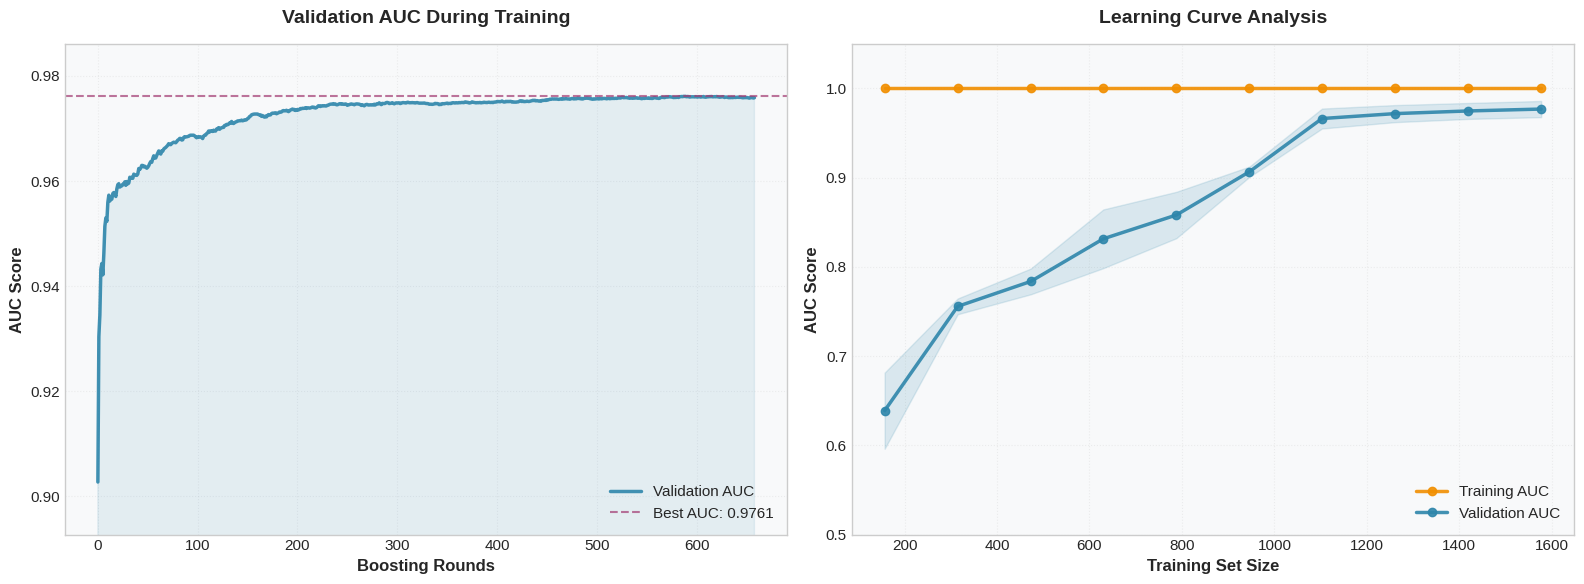

In [14]:
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import learning_curve, StratifiedKFold


# ---------------------------------------------------------
# 1. Model Performance Evaluation


# Get evaluation results recorded during training. This requires the model to be trained with eval_set parameter
evals_result = xgb_model.evals_result()

# Make predictions on validation set
y_val_pred = xgb_model.predict(X_val)
y_val_prob = xgb_model.predict_proba(X_val)[:, 1]  # Returns probabilities for each class

# Calculate evaluation metrics
# AUC (Area Under ROC Curve): Measures model's ability to distinguish between classes
auc = roc_auc_score(y_val, y_val_prob)
# Accuracy: Proportion of correctly predicted samples
acc = accuracy_score(y_val, y_val_pred)

# Print evaluation results
print(f"Validation AUC: {auc:.4f}")
print(f"Validation Accuracy: {acc:.4f}")
print("=" * 50)


# ---------------------------------------------------------
# 2. Visualize Training Process


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Extract AUC history from validation set
val_auc = evals_result['validation_0']['auc']

# Create plot showing how validation AUC changes after each boosting round
# Observe how model performance improves with training rounds. Detect potential overfitting (if validation AUC starts to decrease)
ax1.plot(val_auc,
         color='#2E86AB',
         linewidth=2.5,
         label='Validation AUC',
         alpha=0.9)
ax1.axhline(y=max(val_auc),
            color='#A23B72',
            linestyle='--',
            linewidth=1.5,
            label=f'Best AUC: {max(val_auc):.4f}',
            alpha=0.7)
ax1.fill_between(range(len(val_auc)), val_auc, alpha=0.1, color='#2E86AB')

ax1.set_xlabel('Boosting Rounds', fontsize=12, fontweight='bold')
ax1.set_ylabel('AUC Score', fontsize=12, fontweight='bold')
ax1.set_title('Validation AUC During Training',
              fontsize=14,
              fontweight='bold',
              pad=15)
ax1.legend(loc='lower right', fontsize=11, framealpha=0.9)
ax1.grid(True, alpha=0.3, linestyle=':', linewidth=0.8)
ax1.set_ylim([min(val_auc) - 0.01, max(val_auc) + 0.01])


# ---------------------------------------------------------
# 3. Generate Learning Curve


# Learning_curve requires an untrained estimator
# Create a new estimator with the same hyperparameters as the original model

# Create a new estimator with identical parameters but untrained
base_estimator = XGBClassifier(
    **xgb_model.get_params()  # Use get_params() to retrieve all hyperparameters from the trained model
)

# Set up cross-validation strategy
cv = StratifiedKFold(  # Maintains the same proportion of positive/negative samples
    n_splits=5,  # Split data into 5 folds
    shuffle=True,  # Shuffle data before splitting
    random_state=7  # Random seed for reproducibility
)

# Calculate learning curve
# learning_curve trains the model on different training set sizes and evaluates performance
train_sizes, train_scores, val_scores = learning_curve(
    base_estimator,  # Use untrained estimator
    X_train,
    y_train,
    cv=cv,  # Cross-validation strategy
    scoring='roc_auc',  # Evaluation metric: AUC
    train_sizes=np.linspace(
        0.1, 1.0,
        10),  # Sample 10 points between 10% and 100% of training data
    n_jobs=-1,  # Use all available CPU cores for parallel computation
    verbose=1,  # Display progress information
)

# Calculate average scores for each training set size. Calculate mean across each row (each training set size)
train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
val_scores_mean = val_scores.mean(axis=1)
val_scores_std = val_scores.std(axis=1)

# Plot learning curve
ax2.plot(train_sizes,
         train_scores_mean,
         'o-',
         color='#F18F01',
         linewidth=2.5,
         markersize=6,
         label='Training AUC',
         alpha=0.9)
ax2.plot(train_sizes,
         val_scores_mean,
         'o-',
         color='#2E86AB',
         linewidth=2.5,
         markersize=6,
         label='Validation AUC',
         alpha=0.9)

# Add standard deviation bands
ax2.fill_between(train_sizes,
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std,
                 alpha=0.15,
                 color='#F18F01')
ax2.fill_between(train_sizes,
                 val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std,
                 alpha=0.15,
                 color='#2E86AB')

ax2.set_xlabel('Training Set Size', fontsize=12, fontweight='bold')
ax2.set_ylabel('AUC Score', fontsize=12, fontweight='bold')
ax2.set_title('Learning Curve Analysis',
              fontsize=14,
              fontweight='bold',
              pad=15)
ax2.legend(loc='lower right', fontsize=11, framealpha=0.9)
ax2.grid(True, alpha=0.3, linestyle=':', linewidth=0.8)
ax2.set_ylim([0.5, 1.05])

plt.tight_layout()
plt.show()

### Interpret Learning Curves
* Both training and validation scores are low: **Underfitting**; Solution: Increase model complexity, add more features

* High training score but low validation score with large gap: **Overfitting**; Solution: Add more training data, use regularization, reduce model complexity

* Both curves converge and plateau: **Model has learned sufficiently**; If performance is still unsatisfactory, consider better feature engineering or trying different models

### Model Prediction and Comprehensive Evaluation
* Precision: When false positives are costly (e.g., spam detection)
* Recall: When false negatives are costly (e.g., disease diagnosis)
* F1-Score: When you need balance between precision and recall
* AUC: Overall model performance across all thresholds

MODEL EVALUATION RESULTS
----------------------------------------------------------------------
Primary Performance Metrics:
   Test AUC:      0.7878
   Test Accuracy: 0.8435
----------------------------------------------------------------------
Detailed Classification Report:
                    precision    recall  f1-score   support

Class 0 (Negative)     0.8764    0.9474    0.9105       247
Class 1 (Positive)     0.5185    0.2979    0.3784        47

          accuracy                         0.8435       294
         macro avg     0.6975    0.6226    0.6444       294
      weighted avg     0.8192    0.8435    0.8254       294

----------------------------------------------------------------------
Confusion matrix:
 [[234  13]
 [ 33  14]]


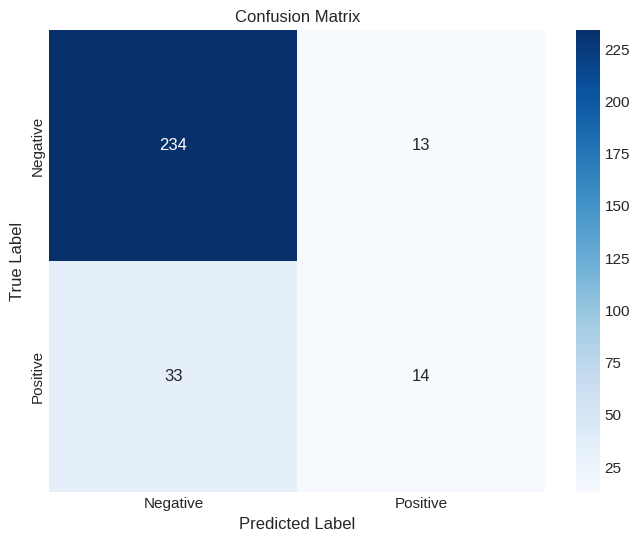


Confusion Matrix Interpretation:
   True Negatives (TN):     234  (Correctly predicted negative)
   False Positives (FP):     13  (Incorrectly predicted positive)
   False Negatives (FN):     33  (Incorrectly predicted negative)
   True Positives (TP):      14  (Correctly predicted positive)


In [15]:
from sklearn.metrics import (roc_auc_score, accuracy_score,
                             classification_report, confusion_matrix)


# ---------------------------------------------------------
# 1. Generate Predictions on Test Set


# Make predictions on test set
y_pred = xgb_model.predict(X_test)

# predict_proba(): Returns probability estimates for each class
# [:, 1] extracts the probability of the positive class (class 1)
y_prob = xgb_model.predict_proba(X_test)[:, 1]


# ---------------------------------------------------------
# 2. Calculate Core Performance Metrics


# Calculate AUC (Area Under ROC Curve)
# AUC measures the model's ability to distinguish between classes
auc = roc_auc_score(y_test, y_prob)

# Calculate Accuracy
# Accuracy is the proportion of correct predictions (both positive and negative)
# Formula: (TP + TN) / (TP + TN + FP + FN). Can be misleading for imbalanced datasets
acc = accuracy_score(y_test, y_pred)


# ---------------------------------------------------------
# 3. Display Results with Professional Formatting


# Print header with visual separation
print("MODEL EVALUATION RESULTS")
print("-" * 70)

# Display primary metrics
print(f"Primary Performance Metrics:")
print(f"   Test AUC:      {auc:.4f}")
print(f"   Test Accuracy: {acc:.4f}")
print("-" * 70)

# Generate and display detailed classification report
# Classification report includes:
#   - Precision: TP / (TP + FP) - How many selected items are relevant
#   - Recall: TP / (TP + FN) - How many relevant items are selected
#   - F1-Score: 2 * (Precision * Recall) / (Precision + Recall)
#   - Support: Number of actual occurrences of each class
print("Detailed Classification Report:")
print(
    classification_report(
        y_test,
        y_pred,
        target_names=['Class 0 (Negative)', 'Class 1 (Positive)'],
        digits=4))


# ---------------------------------------------------------
# 4. Confusion Matrix Analysis


# Calculate confusion matrix
#              Predicted
#              0      1
# Actual  0   TN     FP
#         1   FN     TP
cm = confusion_matrix(y_test, y_pred)
print("-" * 70)
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate and display confusion matrix components
tn, fp, fn, tp = cm.ravel()

print("\nConfusion Matrix Interpretation:")
print(f"   True Negatives (TN):  {tn:>6}  (Correctly predicted negative)")
print(f"   False Positives (FP): {fp:>6}  (Incorrectly predicted positive)")
print(f"   False Negatives (FN): {fn:>6}  (Incorrectly predicted negative)")
print(f"   True Positives (TP):  {tp:>6}  (Correctly predicted positive)")

### ROC and Precision-Recall Curves Visualization
* ROC Curve
  * Shows trade-off between True Positive Rate and False Positive Rate.
  * Good for balanced datasets, overall model performance assessment
* PR Curve
  * Shows trade-off between Precision and Recall.
  * Better for imbalanced datasets, focuses on positive class performance

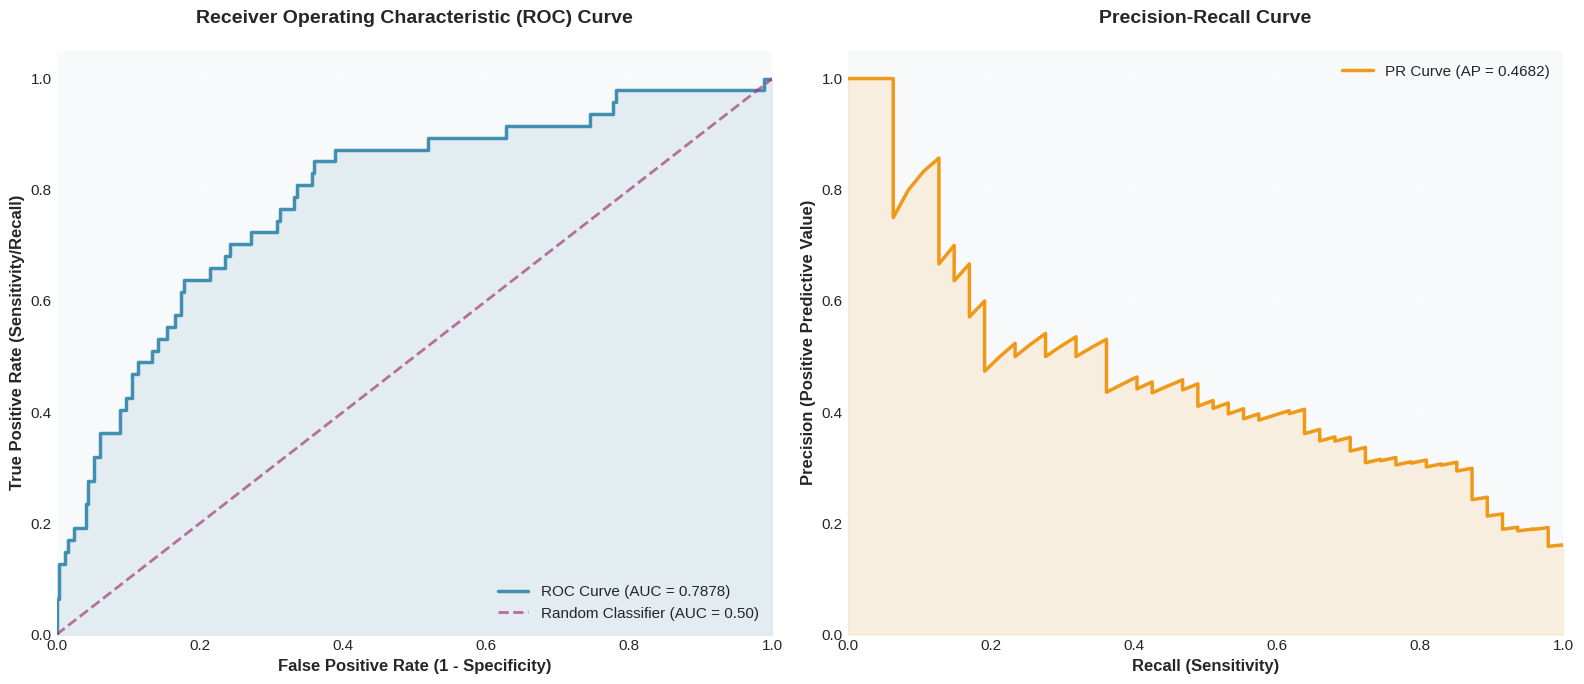

MODEL PERFORMANCE SUMMARY
  ROC-AUC Score:        0.7878
  Average Precision:    0.4682


In [16]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score


# Set global matplotlib style for consistent, professional appearance
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = '#f8f9fa'


# ---------------------------------------------------------
# 1. ROC and Precision-Recall Curves


# Calculate ROC curve coordinates
# fpr: False Positive Rate at different thresholds
# tpr: True Positive Rate (Recall/Sensitivity) at different thresholds
# thresholds: Decision threshold values used to generate fpr and tpr
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate Area Under ROC Curve (AUC-ROC)
roc_auc = roc_auc_score(y_test, y_prob)

# Calculate Precision-Recall curve coordinates
precision, recall, _ = precision_recall_curve(y_test, y_prob)

# Calculate Average Precision (AP) score
# AP summarizes the PR curve as weighted mean of precisions. Equivalent to area under the PR curve
average_precision = average_precision_score(y_test, y_prob)

# Calculate the proportion of positive samples for PR baseline
positive_ratio = y_test.sum() / len(y_test)

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))


# ---------------------------------------------------------
# 2. ROC Curve


# Plot the ROC curve with professional styling
ax1.plot(
    fpr,
    tpr,
    color='#2E86AB',  # Deep blue color
    linewidth=2.5,
    label=f'ROC Curve (AUC = {roc_auc:.4f})',
    alpha=0.9)

# Plot diagonal reference line (random classifier baseline)
ax1.plot(
    [0, 1],
    [0, 1],
    color='#A23B72',  # Contrasting color for reference line
    linestyle='--',
    linewidth=2,
    label='Random Classifier (AUC = 0.50)',
    alpha=0.7)

# Customize ROC plot appearance
ax1.set_xlabel('False Positive Rate (1 - Specificity)',
               fontsize=12,
               fontweight='bold')
ax1.set_ylabel('True Positive Rate (Sensitivity/Recall)',
               fontsize=12,
               fontweight='bold')
ax1.set_title('Receiver Operating Characteristic (ROC) Curve',
              fontsize=14,
              fontweight='bold',
              pad=20)
ax1.legend(loc='lower right', fontsize=11, framealpha=0.9)
ax1.grid(True, alpha=0.3, linestyle=':', linewidth=0.8)
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])

# Add subtle background color to emphasize good performance region
ax1.fill_between(fpr, tpr, alpha=0.1, color='#2E86AB')


# ---------------------------------------------------------
# 3. Precision-Recall Curve


# Plot the PR curve with professional styling
ax2.plot(
    recall,
    precision,
    color='#F18F01',  # Vibrant orange color
    linewidth=2.5,
    label=f'PR Curve (AP = {average_precision:.4f})',
    alpha=0.9)

# Customize PR plot appearance
ax2.set_xlabel('Recall (Sensitivity)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Precision (Positive Predictive Value)',
               fontsize=12,
               fontweight='bold')
ax2.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold', pad=20)
ax2.legend(loc='best', fontsize=11, framealpha=0.9)
ax2.grid(True, alpha=0.3, linestyle=':', linewidth=0.8)
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])

# Add subtle background color to emphasize good performance region
ax2.fill_between(recall, precision, alpha=0.1, color='#F18F01')

# Adjust layout to prevent label cutoff and ensure proper spacing
plt.tight_layout()
plt.show()

print("MODEL PERFORMANCE SUMMARY")
print(f"  ROC-AUC Score:        {roc_auc:.4f}")
print(f"  Average Precision:    {average_precision:.4f}")

###  Feature Importance Analysis

* Higher values indicate features that contribute more to predictions.
* Top features are the most influential in model decisions.
* Features with zero importance can potentially be removed to simplify the model.
* Use this analysis for feature selection and model interpretation

FEATURE IMPORTANCE ANALYSIS


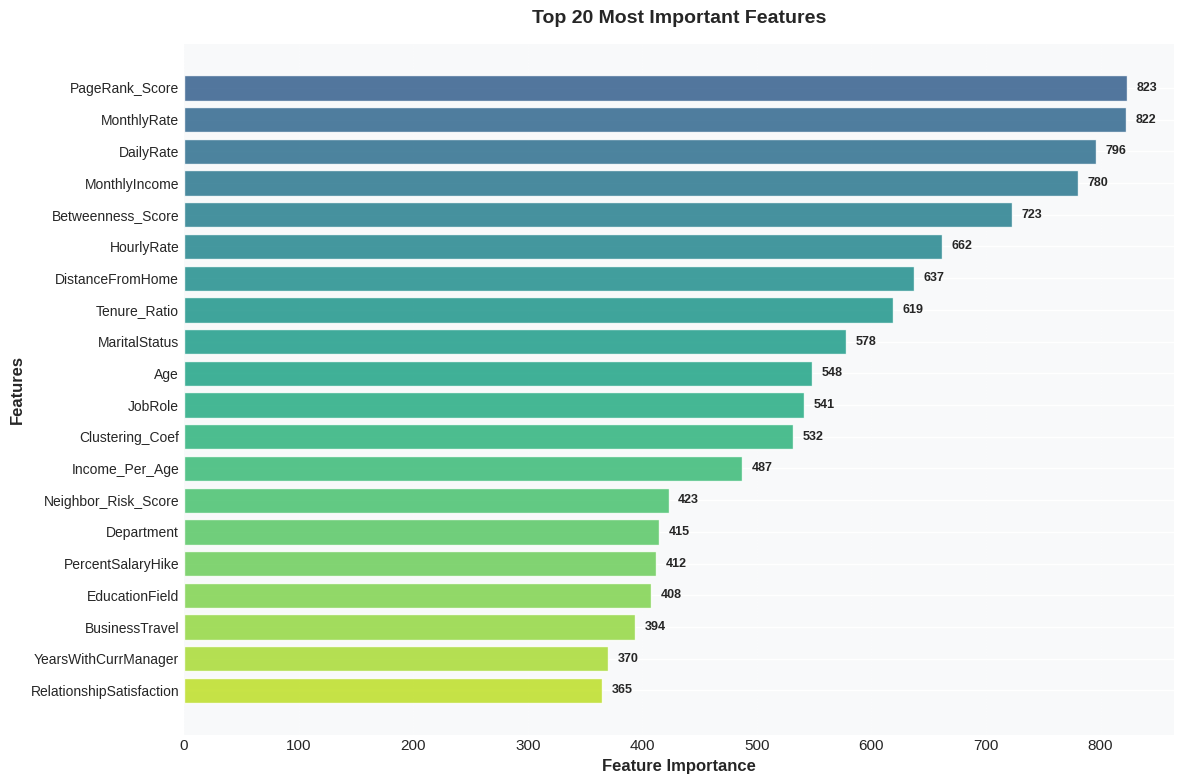


Top 20 Feature Importance Scores:
----------------------------------------------------------------------
Rank   Feature Name                   Importance Score

1      PageRank_Score                          823.00
2      MonthlyRate                             822.00
3      DailyRate                               796.00
4      MonthlyIncome                           780.00
5      Betweenness_Score                       723.00
6      HourlyRate                              662.00
7      DistanceFromHome                        637.00
8      Tenure_Ratio                            619.00
9      MaritalStatus                           578.00
10     Age                                     548.00
11     JobRole                                 541.00
12     Clustering_Coef                         532.00
13     Income_Per_Age                          487.00
14     Neighbor_Risk_Score                     423.00
15     Department                              415.00
16     PercentSalaryHike    

In [17]:
# Feature Importance Analysis with Grouped Encoded Features
print("FEATURE IMPORTANCE ANALYSIS")

# Extract raw feature importance scores
# Using 'weight' (frequency) - number of times feature is used in splits
feature_importance = xgb_model.get_booster().get_score(
    importance_type='weight')


# Map feature names to their base names (grouping encoded variants)
def get_base_feature_name(feature_name):
  """
    Group encoded features by their original categorical variable.

    Examples:
        'Department_Sales' -> 'Department'
        'MaritalStatus_Single' -> 'MaritalStatus'
        'BusinessTravel_label' -> 'BusinessTravel'
        'Gender_bin' -> 'Gender'
        'EducationField_freq' -> 'EducationField'
    """
  # One-hot encoded features (contain underscore with category name)
  if 'Department_' in feature_name:
    return 'Department'
  elif 'MaritalStatus_' in feature_name:
    return 'MaritalStatus'
  # Suffix-based encoded features
  elif feature_name.endswith('_label'):
    return feature_name.replace('_label', '')
  elif feature_name.endswith('_freq'):
    return feature_name.replace('_freq', '')
  elif feature_name.endswith('_bin'):
    return feature_name.replace('_bin', '')
  # Original numerical features (no encoding)
  else:
    return feature_name


# Group importance scores by base feature name
grouped_importance = {}
for feature, score in feature_importance.items():
  base_name = get_base_feature_name(feature)
  if base_name not in grouped_importance:
    grouped_importance[base_name] = 0
  grouped_importance[base_name] += score

# Sort by importance in descending order
importance_sorted = sorted(grouped_importance.items(),
                           key=lambda x: x[1],
                           reverse=True)

# Extract top N features for visualization
n_features_to_plot = min(20, len(importance_sorted))
features = [item[0] for item in importance_sorted[:n_features_to_plot]]
importance_values = [
    item[1] for item in importance_sorted[:n_features_to_plot]
]

# Create professional bar chart
fig, ax = plt.subplots(figsize=(12, 8))

# Create color gradient based on importance
colors = plt.cm.viridis(np.linspace(0.3, 0.9, n_features_to_plot))

bars = ax.barh(range(n_features_to_plot),
               importance_values,
               color=colors,
               alpha=0.85)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, importance_values)):
  ax.text(value + max(importance_values) * 0.01,
          i,
          f'{value:.0f}',
          va='center',
          fontsize=9,
          fontweight='bold')

ax.set_yticks(range(n_features_to_plot))
ax.set_yticklabels(features, fontsize=10)

ax.set_xlabel('Feature Importance', fontsize=12, fontweight='bold')
ax.set_ylabel('Features', fontsize=12, fontweight='bold')
ax.set_title(f'Top {n_features_to_plot} Most Important Features',
             fontsize=14,
             fontweight='bold',
             pad=15)
ax.invert_yaxis()  # Highest importance at top
ax.grid(axis='x', alpha=0.3, linestyle=':', linewidth=0.8)
ax.set_facecolor('#f8f9fa')

plt.tight_layout()
plt.show()

# Print detailed feature importance table
print(f"\nTop {n_features_to_plot} Feature Importance Scores:")
print("-" * 70)
print(f"{'Rank':<6} {'Feature Name':<30} {'Importance Score':>15}")
print()
for i, (feature, score) in enumerate(importance_sorted[:n_features_to_plot],
                                     1):
  print(f"{i:<6} {feature:<30} {score:>15.2f}")

## Module 4: Causal Analysis

**Objective** Evaluate the causal relationships between selected features (treatments) and outcome variables, isolating their independent effect from correlations captured by predictive models.

**Output** Includes estimates of causal effects such as the Average Treatment Effect (ATE), Conditional Average Treatment Effect (CATE), or other relevant causal metrics. Visualizations may include causal graphs, treatment effect distributions, and sensitivity analyses to assess robustness. The module also provides a detailed interpretation of how individual features influence the outcome independently of predictive associations, highlighting actionable insights for decision-making.

##### Purpose
- **Correlation**: Traditional ML finds patterns but can't prove causation
- **Causal Inference**: Identifies what changes in X actually *cause* changes in Y

##### DoWhy Framework Steps
- **Model**: Specify causal graph with treatment, outcome, confounders
- **Identify**: Find causal estimand (what to measure)
- **Estimate**: Quantify the causal effect
- **Refute**: Validate using sensitivity tests

### Causal Analysis of Employee Attrition Using DoWhy

Implements an enhanced causal analysis pipeline for employee attrition using the DoWhy library. Its main purpose is to identify and quantify the causal effects of various factors on employee turnover, rather than just correlations.

**1. Data Preparation**
*  Converts categorical variables to numeric formats for causal modeling.
*  Drops non-informative columns and handles missing values.
*  Generates new binary treatment variables from continuous variables (e.g., HighIncome, LongTenure, FarFromHome) to improve causal effect estimation.*

**2. Multiple Treatment Effects Analysis**
* Defines multiple treatments (interventions) such as OverTime, JobSatisfaction, WorkLifeBalance, etc.
* Selects relevant confounders for each treatment—variables that affect both the treatment and the outcome—to ensure valid causal inference.
* Estimates Average Treatment Effects (ATE) using propensity score matching or linear regression.

**3. Visualization of Causal Effects**
* Creates a horizontal bar chart showing the estimated ATE for each intervention.
* Uses color coding to represent the magnitude and direction of effects (strong positive, moderate positive, moderate negative, strong negative).
* Adds numeric labels on bars for precise interpretation.

**4. Effect Interpretation and Recommendations**
* Sorts factors by their impact on attrition risk.
* Provides actionable HR recommendations based on the strongest causal factors, such as reducing overtime, improving work-life balance, or offering competitive compensation.

ERROR:dowhy.causal_estimator:Propensity score methods are applicable only for binary treatments
ERROR:dowhy.causal_estimator:Propensity score methods are applicable only for binary treatments
ERROR:dowhy.causal_estimator:Propensity score methods are applicable only for binary treatments


ENHANCED EMPLOYEE ATTRITION CAUSAL ANALYSIS

DATA PREPARATION FOR CAUSAL ANALYSIS
Prepared causal dataset: (1470, 34)
Attrition rate: 16.12%
Binary treatment variables created:
  HighIncome: 50.0% of employees
  LongTenure: 47.2% of employees
  FarFromHome: 47.3% of employees
----------------------------------------------------------------------

COMPREHENSIVE CAUSAL EFFECTS ANALYSIS
✓ OverTime                 : ATE =   0.1850  (6 confounders)
✗ JobSatisfaction          : Failed - Propensity score methods are applicable only for binary trea
✗ WorkLifeBalance          : Failed - Propensity score methods are applicable only for binary trea
✗ EnvironmentSatisfaction  : Failed - Propensity score methods are applicable only for binary trea
✓ HighIncome               : ATE =  -0.1143  (6 confounders)
✓ LongTenure               : ATE =  -0.0633  (6 confounders)


✓ FarFromHome              : ATE =   0.0592  (5 confounders)
✓ BusinessTravel           : ATE =   0.0874  (6 confounders)

 Creating causal effects visualization...



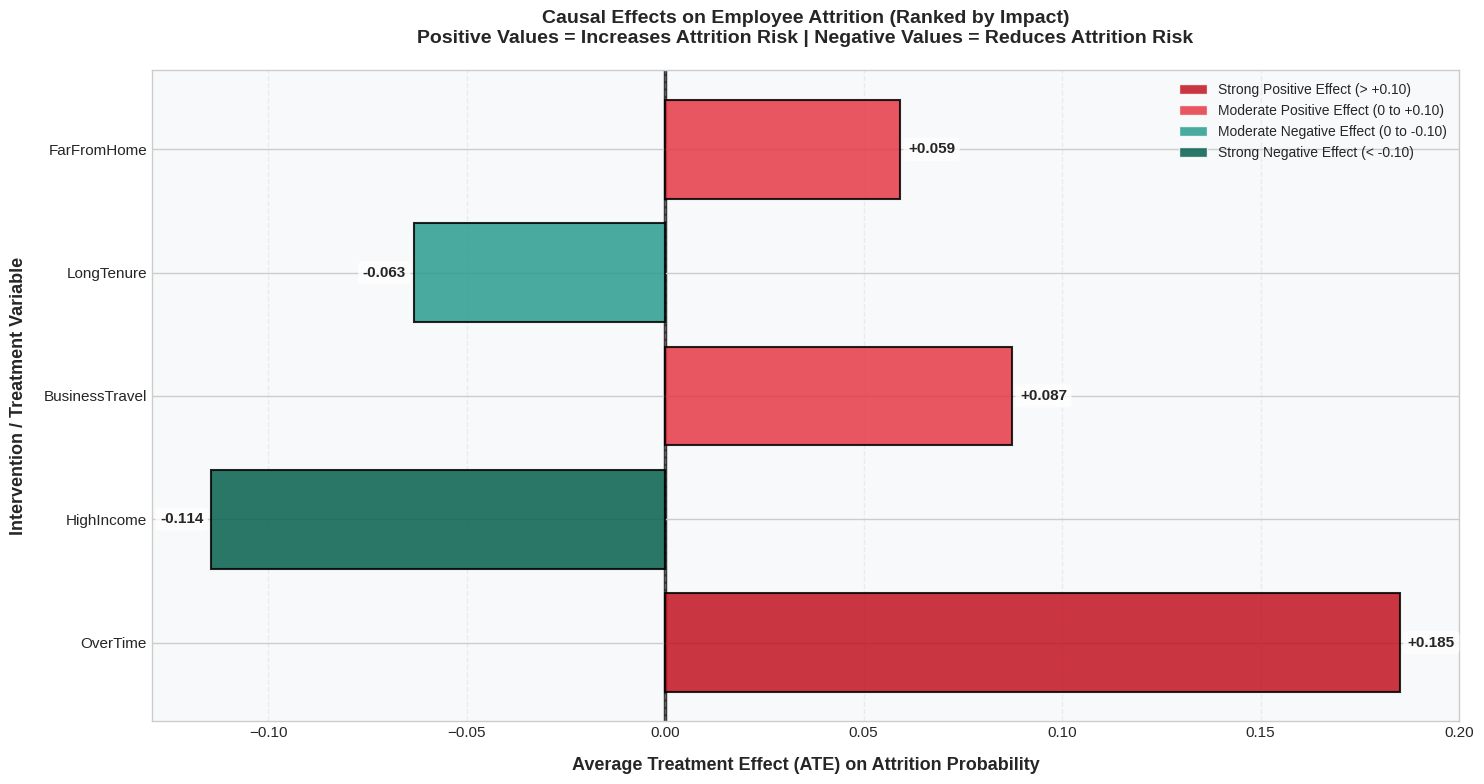

CAUSAL EFFECTS INTERPRETATION & RECOMMENDATIONS

 Top Factors Increasing Attrition Risk:
1. OverTime                 : +0.1850 (STRONG impact).      Increases attrition probability by 18.50 percentage points
2. BusinessTravel           : +0.0874 (MODERATE impact).      Increases attrition probability by 8.74 percentage points
3. FarFromHome              : +0.0592 (MODERATE impact).      Increases attrition probability by 5.92 percentage points
----------------------------------------------------------------------

 Top Factors Reducing Attrition Risk:
1. HighIncome               : -0.1143 (STRONG impact).       Reduces attrition probability by 11.43 percentage points
2. LongTenure               : -0.0633 (MODERATE impact).       Reduces attrition probability by 6.33 percentage points
----------------------------------------------------------------------

Actionable HR Interventions (Ranked by Impact):
• REDUCE OVERTIME: Has strong causal effect (+0.185). Implement overtime monitoring a

In [18]:
# Employee Attrition Causal Analysis using DoWhy


from dowhy import CausalModel
from matplotlib.patches import Patch


# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = '#f8f9fa'


# ---------------------------------------------------------
# 1. Data Preparation for Causal Analysis


def prepare_causal_data(df):
  """
  Prepare data for causal analysis with feature engineering.
  """

  # Create a copy to avoid modifying original
  df_causal = df.copy()

  # Convert binary categorical variables to numeric
  binary_mappings = {
      'Attrition': {
          'Yes': 1,
          'No': 0
      },
      'OverTime': {
          'Yes': 1,
          'No': 0
      },
      'Gender': {
          'Male': 1,
          'Female': 0
      }
  }

  for col, mapping in binary_mappings.items():
    if col in df_causal.columns:
      df_causal[col] = df_causal[col].map(mapping)

  # For categorical variables with more categories, use numeric encoding
  if 'BusinessTravel' in df_causal.columns:
    travel_map = {'Non-Travel': 0, 'Travel_Rarely': 1, 'Travel_Frequently': 2}
    df_causal['BusinessTravel'] = df_causal['BusinessTravel'].map(travel_map)

  # Drop non-informative columns
  cols_to_drop = ['EmployeeNumber', 'Over18', 'StandardHours', 'EmployeeCount']
  df_causal = df_causal.drop(
      columns=[c for c in cols_to_drop if c in df_causal.columns])

  # Keep only numeric columns for simplicity
  numeric_cols = df_causal.select_dtypes(include=[np.number]).columns
  df_causal = df_causal[numeric_cols]

  # Create binned versions of continuous variables for treatment analysis
  # This improves causal estimation for continuous variables
  if 'MonthlyIncome' in df_causal.columns:
    df_causal['HighIncome'] = (
        df_causal['MonthlyIncome']
        > df_causal['MonthlyIncome'].median()).astype(int)

  if 'YearsAtCompany' in df_causal.columns:
    df_causal['LongTenure'] = (df_causal['YearsAtCompany'] > 5).astype(int)

  if 'DistanceFromHome' in df_causal.columns:
    df_causal['FarFromHome'] = (
        df_causal['DistanceFromHome']
        > df_causal['DistanceFromHome'].median()).astype(int)

  # Remove any rows with missing values
  df_causal = df_causal.dropna()

  print("DATA PREPARATION FOR CAUSAL ANALYSIS")
  print(f"Prepared causal dataset: {df_causal.shape}")
  print(f"Attrition rate: {df_causal['Attrition'].mean():.2%}")
  print(f"Binary treatment variables created:")
  if 'HighIncome' in df_causal.columns:
    print(f"  HighIncome: {df_causal['HighIncome'].mean():.1%} of employees")
  if 'LongTenure' in df_causal.columns:
    print(f"  LongTenure: {df_causal['LongTenure'].mean():.1%} of employees")
  if 'FarFromHome' in df_causal.columns:
    print(
        f"  FarFromHome: {df_causal['FarFromHome'].mean():.1%} of employees")
  print("-" * 70 + "\n")

  return df_causal


# ---------------------------------------------------------
# 2. Enhanced Multiple Treatment Effects Analysis


def analyze_multiple_treatments(df_causal):
  """
  Analyze causal effects of multiple interventions with improved confounder selection.
  """

  print("COMPREHENSIVE CAUSAL EFFECTS ANALYSIS")

  # Define treatments with carefully selected confounders
  # Key principle: confounders must affect BOTH treatment AND outcome
  treatments = {
      'OverTime': {
          'confounders': [
              'Age', 'JobLevel', 'MonthlyIncome', 'YearsAtCompany',
              'JobSatisfaction', 'WorkLifeBalance'
          ],
          'method':
          'backdoor.propensity_score_matching'
      },
      'JobSatisfaction': {
          'confounders': [
              'Age', 'MonthlyIncome', 'YearsAtCompany', 'JobLevel',
              'EnvironmentSatisfaction', 'WorkLifeBalance'
          ],
          'method':
          'backdoor.propensity_score_matching'
      },
      'WorkLifeBalance': {
          'confounders': [
              'Age', 'MonthlyIncome', 'YearsAtCompany', 'JobLevel',
              'JobSatisfaction', 'EnvironmentSatisfaction'
          ],
          'method':
          'backdoor.propensity_score_matching'
      },
      'EnvironmentSatisfaction': {
          'confounders': [
              'Age', 'MonthlyIncome', 'YearsAtCompany', 'JobLevel',
              'JobSatisfaction', 'WorkLifeBalance'
          ],
          'method':
          'backdoor.propensity_score_matching'
      },
      'HighIncome': {
          'confounders': [
              'Age', 'Education', 'JobLevel', 'YearsAtCompany',
              'PerformanceRating', 'TotalWorkingYears'
          ],
          'method':
          'backdoor.propensity_score_matching'
      },
      'LongTenure': {
          'confounders': [
              'Age', 'JobLevel', 'MonthlyIncome', 'JobSatisfaction',
              'EnvironmentSatisfaction', 'WorkLifeBalance'
          ],
          'method':
          'backdoor.propensity_score_matching'
      },
      'FarFromHome': {
          'confounders': [
              'Age', 'MonthlyIncome', 'JobLevel', 'MaritalStatus',
              'WorkLifeBalance', 'JobSatisfaction'
          ],
          'method':
          'backdoor.propensity_score_matching'
      },
      'BusinessTravel': {
          'confounders': [
              'Age', 'JobLevel', 'MonthlyIncome', 'YearsAtCompany',
              'JobSatisfaction', 'WorkLifeBalance'
          ],
          'method':
          'backdoor.linear_regression'
      }
  }

  results = {}

  for treatment, config in treatments.items():

    confounders = config['confounders']
    method = config['method']

    # Filter confounders that exist in dataset
    available_confounders = [c for c in confounders if c in df_causal.columns]

    if len(available_confounders) < 2:
      print(f" Skipping {treatment}: Insufficient confounders")
      continue

    try:
      # Create causal model
      model = CausalModel(data=df_causal,
                          treatment=treatment,
                          outcome='Attrition',
                          common_causes=available_confounders)

      # Identify causal estimand
      identified_estimand = model.identify_effect(
          proceed_when_unidentifiable=True)

      # Estimate causal effect
      estimate = model.estimate_effect(identified_estimand, method_name=method)

      # Store results
      results[treatment] = {
          'ate': estimate.value,
          'method': method,
          'n_confounders': len(available_confounders)
      }

      print(
          f"✓ {treatment:25s}: ATE = {estimate.value:>8.4f}  ({len(available_confounders)} confounders)"
      )

    except Exception as e:
      error_msg = str(e)[:60]
      print(f"✗ {treatment:25s}: Failed - {error_msg}")
      continue

  return results


# ---------------------------------------------------------
# 3. Visualization with Effect Sizes


def visualize_causal_effects_enhanced(effects_dict, top_n=10):
  """
  Create visualization showing causal effects with better design.
  """

  # Extract ATE values
  ate_data = [(k, v['ate']) for k, v in effects_dict.items()]

  # Sort by absolute effect size
  sorted_effects = sorted(ate_data, key=lambda x: abs(x[1]),
                          reverse=True)[:top_n]
  treatments = [item[0] for item in sorted_effects]
  effects = [item[1] for item in sorted_effects]

  # Create figure with better layout
  fig, ax = plt.subplots(figsize=(15, 8))

  # Color based on direction and magnitude
  colors = []
  for e in effects:
    if e > 0.1:
      colors.append('#C1121F')  # Strong red for large positive effects
    elif e > 0:
      colors.append('#E63946')  # Light red for small positive effects
    elif e > -0.1:
      colors.append('#2A9D8F')  # Light green for small negative effects
    else:
      colors.append('#06604E')  # Dark green for large negative effects

  # Create horizontal bar chart
  bars = ax.barh(treatments,
                 effects,
                 color=colors,
                 alpha=0.85,
                 edgecolor='black',
                 linewidth=1.5)

  # Add value labels with better formatting
  for bar, value in zip(bars, effects):
    width = bar.get_width()
    label_x = width + (0.002 if width > 0 else -0.002)
    ha = 'left' if width > 0 else 'right'

    # Format label with sign
    label_text = f'+{value:.3f}' if value > 0 else f'{value:.3f}'

    ax.text(label_x,
            bar.get_y() + bar.get_height() / 2,
            label_text,
            ha=ha,
            va='center',
            fontweight='bold',
            fontsize=11,
            bbox=dict(boxstyle='round,pad=0.3',
                      facecolor='white',
                      alpha=0.8,
                      edgecolor='none'))

  # Add reference line at 0
  ax.axvline(x=0,
             color='black',
             linestyle='-',
             linewidth=2.5,
             alpha=0.8,
             zorder=0)

  # Customize axes
  ax.set_xlabel('Average Treatment Effect (ATE) on Attrition Probability',
                fontsize=13,
                fontweight='bold',
                labelpad=12)
  ax.set_ylabel('Intervention / Treatment Variable',
                fontsize=13,
                fontweight='bold',
                labelpad=12)
  ax.set_title(
      'Causal Effects on Employee Attrition (Ranked by Impact)\n'
      'Positive Values = Increases Attrition Risk | Negative Values = Reduces Attrition Risk',
      fontsize=14,
      fontweight='bold',
      pad=20)

  # Improve grid
  ax.grid(axis='x', alpha=0.3, linestyle='--', linewidth=1)
  ax.set_axisbelow(True)

  # Add legend with better styling
  legend_elements = [
      Patch(facecolor='#C1121F',
            label='Strong Positive Effect (> +0.10)',
            alpha=0.85),
      Patch(facecolor='#E63946',
            label='Moderate Positive Effect (0 to +0.10)',
            alpha=0.85),
      Patch(facecolor='#2A9D8F',
            label='Moderate Negative Effect (0 to -0.10)',
            alpha=0.85),
      Patch(facecolor='#06604E',
            label='Strong Negative Effect (< -0.10)',
            alpha=0.85)
  ]
  ax.legend(handles=legend_elements,
            loc='best',
            fontsize=10,
            framealpha=0.95,
            edgecolor='black')

  plt.tight_layout()
  plt.show()


# ---------------------------------------------------------
# 4. Effect Size Interpretation and Recommendations


def interpret_causal_effects(effects_dict):
  """
  Provide interpretation and actionable recommendations.
  """

  # Extract ATE values
  ate_data = [(k, v['ate']) for k, v in effects_dict.items()]
  sorted_effects = sorted(ate_data, key=lambda x: abs(x[1]), reverse=True)

  print("CAUSAL EFFECTS INTERPRETATION & RECOMMENDATIONS")

  print("\n Top Factors Increasing Attrition Risk:")
  positive_effects = [(t, e) for t, e in sorted_effects if e > 0]
  if positive_effects:
    for i, (treatment, effect) in enumerate(positive_effects[:5], 1):
      impact = "STRONG" if abs(effect) > 0.1 else "MODERATE"
      print(
          f"{i}. {treatment:25s}: +{effect:.4f} ({impact} impact).      Increases attrition probability by {effect*100:.2f} percentage points"
      )
  else:
    print("No factors found that increase attrition")

  print("-" * 70)
  print("\n Top Factors Reducing Attrition Risk:")

  negative_effects = [(t, e) for t, e in sorted_effects if e < 0]
  if negative_effects:
    for i, (treatment, effect) in enumerate(negative_effects[:5], 1):
      impact = "STRONG" if abs(effect) > 0.1 else "MODERATE"
      print(
          f"{i}. {treatment:25s}: {effect:.4f} ({impact} impact).       Reduces attrition probability by {abs(effect)*100:.2f} percentage points"
      )
  else:
    print("No factors found that reduce attrition")

  print("-" * 70)
  print("\nActionable HR Interventions (Ranked by Impact):")


  # Generate recommendations based on top effects
  recommendations = []

  for treatment, effect in sorted_effects[:3]:
    if 'OverTime' in treatment and effect > 0:
      recommendations.append(
          f"• REDUCE OVERTIME: Has strong causal effect (+{effect:.3f}). "
          f"Implement overtime monitoring and workload rebalancing.")
    elif 'Satisfaction' in treatment:
      if effect > 0:
        recommendations.append(
            f"• IMPROVE {treatment.upper()}: Low satisfaction causally increases "
            f"attrition (+{effect:.3f}). Conduct engagement surveys and act on feedback."
        )
      else:
        recommendations.append(
            f"• MAINTAIN {treatment.upper()}: Protective factor ({effect:.3f}). "
            f"Continue current satisfaction initiatives.")
    elif 'Income' in treatment or 'HighIncome' in treatment:
      if effect < 0:
        recommendations.append(
            f"• COMPETITIVE COMPENSATION: Higher income reduces attrition ({effect:.3f}). "
            f"Review salary benchmarks and retention bonuses.")
    elif 'Tenure' in treatment or 'LongTenure' in treatment:
      if effect < 0:
        recommendations.append(
            f"• RETENTION PROGRAMS: Tenure reduces attrition ({effect:.3f}). "
            f"Implement long-term incentives and career development.")
    elif 'Balance' in treatment and effect > 0:
      recommendations.append(
          f"• WORK-LIFE BALANCE: Critical factor (+{effect:.3f}). "
          f"Introduce flexible work arrangements and wellness programs.")

  for rec in recommendations:
    print(rec)


# ---------------------------------------------------------
# 5. Main Execution Function


def run_enhanced_causal_analysis(df):
  """
  Execute complete enhanced causal analysis pipeline.
  """

  print("ENHANCED EMPLOYEE ATTRITION CAUSAL ANALYSIS")
  print()

  # Step 1: Prepare data
  df_causal = prepare_causal_data(df)

  # Step 2: Analyze multiple treatments
  effects = analyze_multiple_treatments(df_causal)

  if not effects:
    print("No causal effects could be estimated. Check data quality.")
    return df_causal, effects

  # Step 3: Visualize results
  print("\n Creating causal effects visualization...\n")
  visualize_causal_effects_enhanced(effects, top_n=10)

  # Step 4: Interpret and provide recommendations
  interpret_causal_effects(effects)

  return df_causal, effects


df_causal, causal_effects = run_enhanced_causal_analysis(df)

##### Statistical Notes
- **ATE** = Average Treatment Effect (percentage point change)
- **Positive ATE** = increases attrition probability
- **Negative ATE** = decreases attrition probability